# Libraries and Packages

In [1]:
# from google.colab import drive
import os
# basic
import pandas as pd
import numpy as np
# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.impute import SimpleImputer
# statsmodel
import statsmodels.api as sm
# scipy.stats
from scipy.stats import shapiro
# plot
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# itertools
from itertools import combinations
# xgboost
from xgboost import XGBClassifier
# joblib
import joblib
# imblearn
from imblearn.over_sampling import SMOTE

# Data Preprocessing and Transformation

In [2]:
# drive.mount('/content/drive', force_remount=True)

# Load the main application_train dataset
file_path = 'C:/Users/sxiny/Downloads/12.16 MMF2030 Project/Project/Data/'
# file_path = '/Users/shuqichang/Shuqi/School/UT MMF/School/Machine Learning/Assign/Data/'
application_train = pd.read_csv(file_path+'application_train.csv')

# Define paths for the other datasets
datasets_paths = {
    "bureau": file_path+"bureau.csv",
    "bureau_balance": file_path+"bureau_balance.csv",
    "pos_cash_balance": file_path+"POS_CASH_balance.csv",
    "credit_card_balance": file_path+"credit_card_balance.csv",
    "previous_application": file_path+"previous_application.csv",
    "installments_payments": file_path+"installments_payments.csv"
}

# Load the datasets
loaded_datasets = {name: pd.read_csv(path) for name, path in datasets_paths.items()}

In [3]:
def preprocess_data_general(df, dataset_name, missing_threshold=0.4, imbalance_threshold=0.9):

    print(f"Preprocessing {dataset_name}...")

    # 1. Remove high missing rate variables
    missing_ratio = df.isnull().mean()
    high_missing_cols = missing_ratio[missing_ratio > missing_threshold].index.tolist()
    if high_missing_cols:
        print(f"Dropping columns with > {missing_threshold*100}% missing values: {high_missing_cols}")
        df = df.drop(columns=high_missing_cols)

    # 2. Remove constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        print(f"Dropping constant columns: {constant_cols}")
        df = df.drop(columns=constant_cols)

    # 3. Transform binary categorical columns to 0/1
    binary_cols = [col for col in df.select_dtypes(include=['object']).columns if df[col].nunique() == 2]
    if binary_cols:
        print(f"Transforming binary categorical columns to 0/1: {binary_cols}")
        for col in binary_cols:
            df[col] = df[col].map({df[col].unique()[0]: 0, df[col].unique()[1]: 1})

    # 4. Fill missing values
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col] = df[col].fillna(0)  # Fill numerical columns with 0
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna('Unknown')  # Fill categorical columns with 'Unknown'

    # 5. Normalize categorical columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.upper().str.strip()

    return df

def preprocess_application_train(df):

    print("Preprocessing application_train...")

    # Transform CODE_GENDER
    df['CODE_GENDER'] = df['CODE_GENDER'].map({'M': 1}).fillna(0)

    # Transform NAME_TYPE_SUITE to dummy SUITE_ACCOMPANIED
    df['SUITE_ACCOMPANIED'] = df['NAME_TYPE_SUITE'].str.upper().map(
        lambda x: 0 if x in ['UNACCOMPANIED', 'UNKNOWN'] else 1
    ).fillna(0)

    # NAME_INCOME_TYPE to INCOME_SOURCE
    df['INCOME_SOURCE'] = df['NAME_INCOME_TYPE'].str.upper().map(
        lambda x: 1 if x in ['WORKING', 'COMMERCIAL ASSOCIATE', 'PENSIONER', 'STATE SERVANT', 'BUSINESSMAN'] else 0
    ).fillna(0)

    # NAME_EDUCATION_TYPE to HIGHER_EDU
    df['HIGHER_EDU'] = df['NAME_EDUCATION_TYPE'].str.upper().map(
        lambda x: 1 if x in ['HIGHER EDUCATION', 'ACADEMIC DEGREE'] else 0
    ).fillna(0)

    # NAME_FAMILY_STATUS to MARRIED dummy variable
    df['MARRIED'] = df['NAME_FAMILY_STATUS'].str.upper().map(
        lambda x: 1 if x in ['MARRIED', 'CIVIL MARRIAGE'] else 0
    ).fillna(0)

    # Drop useless columns
    columns_to_drop = [
        'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
        'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'
    ]
    print(f"Dropping columns: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop, errors='ignore')

    return df

def preprocess_previous_application(df):

    print("Preprocessing previous_application...")

    # Transform NAME_CONTRACT_STATUS to dummy variable
    df['CONTRACT_APPROVED'] = df['NAME_CONTRACT_STATUS'].str.upper().map(
        lambda x: 1 if x == 'APPROVED' else 0
    ).fillna(0)

    # Drop columns
    columns_to_drop = [
        'NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
        'NAME_CASH_LOAN_PURPOSE', 'NAME_PAYMENT_TYPE',
        'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
        'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
        'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
        'CHANNEL_TYPE', 'SELLERPLACE_AREA',
        'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT',
        'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_CONTRACT_STATUS'
    ]
    print(f"Dropping columns: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop, errors='ignore')

    return df

def preprocess_bureau(df):

    print("Preprocessing bureau...")
    columns_to_drop = ['CREDIT_CURRENCY', 'CREDIT_TYPE']
    print(f"Dropping columns: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

def preprocess_pos_cash_balance(df):
    """
    Preprocesses the POS_CASH_balance dataset by transforming and cleaning specified columns.
    
    Args:
        df (pd.DataFrame): The input DataFrame for POS_CASH_balance.

    Returns:
        pd.DataFrame: The cleaned and transformed DataFrame.
    """
    print("Preprocessing POS_CASH_balance...")

    # Transform NAME_CONTRACT_STATUS to dummy variable
    if 'NAME_CONTRACT_STATUS' in df.columns:
        print("Transforming NAME_CONTRACT_STATUS to CONTRACT_APPROVED dummy variable...")
        df['CONTRACT_APPROVED'] = df['NAME_CONTRACT_STATUS'].str.upper().map(
            lambda x: 1 if x in ['APPROVED', 'ACTIVE', 'COMPLETED', 'SIGNED'] else 0
        ).fillna(0)

    # Drop columns
    columns_to_drop = ['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE']
    print(f"Dropping columns: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop, errors='ignore')

    return df

In [4]:
# Apply general+specific preprocessing to all datasets
application_train = preprocess_data_general(application_train, "application_train")
application_train = preprocess_application_train(application_train)

loaded_datasets['bureau'] = preprocess_data_general(loaded_datasets['bureau'], "bureau")
loaded_datasets['bureau'] = preprocess_bureau(loaded_datasets['bureau'])

loaded_datasets['bureau_balance'] = preprocess_data_general(loaded_datasets['bureau_balance'], "bureau_balance")
loaded_datasets['credit_card_balance'] = preprocess_data_general(loaded_datasets['credit_card_balance'], "credit_card_balance")
loaded_datasets['installments_payments'] = preprocess_data_general(loaded_datasets['installments_payments'], "installments_payments")

loaded_datasets['pos_cash_balance'] = preprocess_data_general(loaded_datasets['pos_cash_balance'], "POS_CASH_balance")
loaded_datasets['pos_cash_balance'] = preprocess_pos_cash_balance(loaded_datasets['pos_cash_balance'])

loaded_datasets['previous_application'] = preprocess_data_general(loaded_datasets['previous_application'], "previous_application")
loaded_datasets['previous_application'] = preprocess_previous_application(loaded_datasets['previous_application'])

Preprocessing application_train...
Dropping columns with > 40.0% missing values: ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE

# Feature Engineering

In [5]:
# Feature Engineering Process
# -----------------------------

# 1. Bureau / Bureau Balance Features

bureau = loaded_datasets['bureau']
bureau_balance = loaded_datasets['bureau_balance']

status_mapping = {
    "C": -1,  # Closed
    "X": 0,   # Unknown
    "0": 1,   # No DPD
    "1": 2,   # 1-30 DPD
    "2": 3,   # 31-60 DPD
    "3": 4,   # 61-90 DPD
    "4": 5,   # 91-120 DPD
    "5": 6    # 120+ DPD
}
bureau_balance["STATUS"] = bureau_balance["STATUS"].map(status_mapping)

bureau_balance_features = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].agg(
    LATEST_STATUS='last',
    WORST_STATUS='max',
    AVERAGE_STATUS='mean'
).reset_index()

bureau = bureau.merge(bureau_balance_features,on='SK_ID_BUREAU',how='left')

In [6]:
bureau_features = bureau.groupby("SK_ID_CURR").agg(
    BUREAU_NUM_CREDIT=("SK_ID_BUREAU", "count"),
    BUREAU_DAYS_CREDIT_MIN=("DAYS_CREDIT", "min"),
    BUREAU_DAYS_CREDIT_MAX=("DAYS_CREDIT", "max"),
    BUREAU_CREDIT_DAY_OVERDUE_MAX=("CREDIT_DAY_OVERDUE", "max"),
    BUREAU_CREDIT_DAY_OVERDUE_MEAN=("CREDIT_DAY_OVERDUE", "mean"),
    BUREAU_DAYS_CREDIT_ENDDATE_MEAN=("DAYS_CREDIT_ENDDATE", "mean"),
    BUREAU_DAYS_CREDIT_ENDDATE_MAX=("DAYS_CREDIT_ENDDATE", "max"),
    BUREAU_DAYS_CREDIT_ENDDATE_MIN=("DAYS_CREDIT_ENDDATE", "min"),
    BUREAU_DAYS_ENDDATE_FACT_MIN=("DAYS_ENDDATE_FACT", "min"),
    BUREAU_DAYS_ENDDATE_FACT_MEAN=("DAYS_ENDDATE_FACT", "mean"),
    BUREAU_CNT_CREDIT_PROLONG_MAX=("CNT_CREDIT_PROLONG", "max"),
    BUREAU_CNT_CREDIT_PROLONG_MIN=("CNT_CREDIT_PROLONG", "min"),
    BUREAU_AMT_CREDIT_SUM=("AMT_CREDIT_SUM", "sum"),
    BUREAU_AMT_CREDIT_SUM_DEBT=("AMT_CREDIT_SUM_DEBT", "sum"),
    BUREAU_AMT_CREDIT_SUM_LIMIT=("AMT_CREDIT_SUM_LIMIT", "sum"),
    BUREAU_AMT_CREDIT_SUM_OVERDUE=("AMT_CREDIT_SUM_OVERDUE", "sum"),
    BUREAU_DAYS_CREDIT_UPDATE_MEAN=("DAYS_CREDIT_UPDATE", "mean"),
    BUREAU_DAYS_CREDIT_UPDATE_MAX=("DAYS_CREDIT_UPDATE", "max"),
    BUREAU_DAYS_CREDIT_UPDATE_MIN=("DAYS_CREDIT_UPDATE", "min"),
    BUREAU_LATEST_STATUS_MAX=("LATEST_STATUS", lambda x: x.max(skipna=True)),
    BUREAU_LATEST_STATUS_SUM=("LATEST_STATUS", lambda x: x.sum(skipna=True)),
    BUREAU_LATEST_STATUS_MEAN=("LATEST_STATUS", lambda x: x.mean(skipna=True)),
    BUREAU_WORST_STATUS_MAX=("WORST_STATUS", lambda x: x.max(skipna=True)),
    BUREAU_WORST_STATUS_MEAN=("WORST_STATUS", lambda x: x.mean(skipna=True)),
    BUREAU_WORST_STATUS_SUM=("WORST_STATUS", lambda x: x.sum(skipna=True)),
    BUREAU_AVERAGE_STATUS_MAX=("AVERAGE_STATUS", lambda x: x.max(skipna=True)),
    BUREAU_AVERAGE_STATUS_MEAN=("AVERAGE_STATUS", lambda x: x.mean(skipna=True)),
    BUREAU_AVERAGE_STATUS_SUM=("AVERAGE_STATUS", lambda x: x.sum(skipna=True)),
).reset_index()

credit_active_ratio = bureau.groupby("SK_ID_CURR")["CREDIT_ACTIVE"].apply(
    lambda x: (x == "ACTIVE").sum() / len(x)
).reset_index(name="BUREAU_CREDIT_ACTIVE_RATIO")

bureau_features = bureau_features.merge(credit_active_ratio, on="SK_ID_CURR", how="left")

features = application_train.merge(bureau_features, on="SK_ID_CURR", how="left")

In [7]:
# 2. POS Cash Balance Features
pos_cash_balance = loaded_datasets['pos_cash_balance']
pos_cash_balance = pos_cash_balance.sort_values(by=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE']).reset_index(drop=True)
pos_cash_agg = pos_cash_balance.groupby('SK_ID_CURR').agg(
    SK_DPD_MAX=("SK_DPD", "max"),
    SK_DPD_MEAN=("SK_DPD", "mean"),
    SK_DPD_SUM=("SK_DPD", "sum"),
).reset_index()
features = features.merge(pos_cash_agg, on='SK_ID_CURR', how='left')

In [8]:
# 3. Credit Card Balance Features

credit_card_balance = loaded_datasets['credit_card_balance'].sort_values(by=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE']).reset_index(drop=True)

In [9]:
credit_card_agg = credit_card_balance.groupby('SK_ID_CURR').agg(
    CREDIT_CARD_AMT_BALANCE_MAX=("AMT_BALANCE", "max"),
    CREDIT_CARD_AMT_BALANCE_MEAN=("AMT_BALANCE", "mean"),
    CREDIT_CARD_AMT_BALANCE_SUM=("AMT_BALANCE", "sum"),

    CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_MAX=("AMT_CREDIT_LIMIT_ACTUAL", "max"),
    CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_MEAN=("AMT_CREDIT_LIMIT_ACTUAL", "mean"),
    CREDIT_CARD_AMT_CREDIT_LIMIT_ACTUAL_SUM=("AMT_CREDIT_LIMIT_ACTUAL", "sum"),

    CREDIT_CARD_AMT_DRAWINGS_ATM_CURRENT_MAX=("AMT_DRAWINGS_ATM_CURRENT", "max"),
    CREDIT_CARD_AMT_DRAWINGS_ATM_CURRENT_MEAN=("AMT_DRAWINGS_ATM_CURRENT", "mean"),
    CREDIT_CARD_AMT_DRAWINGS_ATM_CURRENT_SUM=("AMT_DRAWINGS_ATM_CURRENT", "sum"),

    CREDIT_CARD_AMT_DRAWINGS_CURRENT_MAX=("AMT_DRAWINGS_CURRENT", "max"),
    CREDIT_CARD_AMT_DRAWINGS_CURRENT_MEAN=("AMT_DRAWINGS_CURRENT", "mean"),
    CREDIT_CARD_AMT_DRAWINGS_CURRENT_SUM=("AMT_DRAWINGS_CURRENT", "sum"),

    CREDIT_CARD_AMT_DRAWINGS_OTHER_CURRENT_MAX=("AMT_DRAWINGS_OTHER_CURRENT", "max"),
    CREDIT_CARD_AMT_DRAWINGS_OTHER_CURRENT_MEAN=("AMT_DRAWINGS_OTHER_CURRENT", "mean"),
    CREDIT_CARD_AMT_DRAWINGS_OTHER_CURRENT_SUM=("AMT_DRAWINGS_OTHER_CURRENT", "sum"),

    CREDIT_CARD_AMT_DRAWINGS_POS_CURRENT_MAX=("AMT_DRAWINGS_POS_CURRENT", "max"),
    CREDIT_CARD_AMT_DRAWINGS_POS_CURRENT_MEAN=("AMT_DRAWINGS_POS_CURRENT", "mean"),
    CREDIT_CARD_AMT_DRAWINGS_POS_CURRENT_SUM=("AMT_DRAWINGS_POS_CURRENT", "sum"),

    CREDIT_CARD_AMT_INST_MIN_REGULARITY_MAX=("AMT_INST_MIN_REGULARITY", "max"),
    CREDIT_CARD_AMT_INST_MIN_REGULARITY_MEAN=("AMT_INST_MIN_REGULARITY", "mean"),
    CREDIT_CARD_AMT_INST_MIN_REGULARITY_SUM=("AMT_INST_MIN_REGULARITY", "sum"),

    CREDIT_CARD_AMT_PAYMENT_CURRENT_MAX=("AMT_PAYMENT_CURRENT", "max"),
    CREDIT_CARD_AMT_PAYMENT_CURRENT_MEAN=("AMT_PAYMENT_CURRENT", "mean"),
    CREDIT_CARD_AMT_PAYMENT_CURRENT_SUM=("AMT_PAYMENT_CURRENT", "sum"),

    CREDIT_CARD_AMT_PAYMENT_TOTAL_CURRENT_MAX=("AMT_PAYMENT_TOTAL_CURRENT", "max"),
    CREDIT_CARD_AMT_PAYMENT_TOTAL_CURRENT_MEAN=("AMT_PAYMENT_TOTAL_CURRENT", "mean"),
    CREDIT_CARD_AMT_PAYMENT_TOTAL_CURRENT_SUM=("AMT_PAYMENT_TOTAL_CURRENT", "sum"),

    CREDIT_CARD_AMT_RECEIVABLE_PRINCIPAL_MAX=("AMT_RECEIVABLE_PRINCIPAL", "max"),
    CREDIT_CARD_AMT_RECEIVABLE_PRINCIPAL_MEAN=("AMT_RECEIVABLE_PRINCIPAL", "mean"),
    CREDIT_CARD_AMT_RECEIVABLE_PRINCIPAL_SUM=("AMT_RECEIVABLE_PRINCIPAL", "sum"),

    CREDIT_CARD_AMT_RECIVABLE_MAX=("AMT_RECIVABLE", "max"),
    CREDIT_CARD_AMT_RECIVABLE_MEAN=("AMT_RECIVABLE", "mean"),
    CREDIT_CARD_AMT_RECIVABLE_SUM=("AMT_RECIVABLE", "sum"),

    CREDIT_CARD_AMT_TOTAL_RECEIVABLE_MAX=("AMT_TOTAL_RECEIVABLE", "max"),
    CREDIT_CARD_AMT_TOTAL_RECEIVABLE_MEAN=("AMT_TOTAL_RECEIVABLE", "mean"),
    CREDIT_CARD_AMT_TOTAL_RECEIVABLE_SUM=("AMT_TOTAL_RECEIVABLE", "sum"),

    CREDIT_CARD_CNT_DRAWINGS_ATM_CURRENT_MAX=("CNT_DRAWINGS_ATM_CURRENT", "max"),
    CREDIT_CARD_CNT_DRAWINGS_ATM_CURRENT_MEAN=("CNT_DRAWINGS_ATM_CURRENT", "mean"),
    CREDIT_CARD_CNT_DRAWINGS_ATM_CURRENT_SUM=("CNT_DRAWINGS_ATM_CURRENT", "sum"),

    CREDIT_CARD_CNT_DRAWINGS_CURRENT_MAX=("CNT_DRAWINGS_CURRENT", "max"),
    CREDIT_CARD_CNT_DRAWINGS_CURRENT_MEAN=("CNT_DRAWINGS_CURRENT", "mean"),
    CREDIT_CARD_CNT_DRAWINGS_CURRENT_SUM=("CNT_DRAWINGS_CURRENT", "sum"),

    CREDIT_CARD_CNT_DRAWINGS_OTHER_CURRENT_MAX=("CNT_DRAWINGS_OTHER_CURRENT", "max"),
    CREDIT_CARD_CNT_DRAWINGS_OTHER_CURRENT_MEAN=("CNT_DRAWINGS_OTHER_CURRENT", "mean"),
    CREDIT_CARD_CNT_DRAWINGS_OTHER_CURRENT_SUM=("CNT_DRAWINGS_OTHER_CURRENT", "sum"),

    CREDIT_CARD_CNT_DRAWINGS_POS_CURRENT_MAX=("CNT_DRAWINGS_POS_CURRENT", "max"),
    CREDIT_CARD_CNT_DRAWINGS_POS_CURRENT_MEAN=("CNT_DRAWINGS_POS_CURRENT", "mean"),
    CREDIT_CARD_CNT_DRAWINGS_POS_CURRENT_SUM=("CNT_DRAWINGS_POS_CURRENT", "sum"),

    CREDIT_CARD_CNT_INSTALMENT_MATURE_CUM_MAX=("CNT_INSTALMENT_MATURE_CUM", "max"),
    CREDIT_CARD_CNT_INSTALMENT_MATURE_CUM_MEAN=("CNT_INSTALMENT_MATURE_CUM", "mean"),
    CREDIT_CARD_CNT_INSTALMENT_MATURE_CUM_SUM=("CNT_INSTALMENT_MATURE_CUM", "sum"),

    CREDIT_CARD_SK_DPD_MAX=("SK_DPD", "max"),
    CREDIT_CARD_SK_DPD_MEAN=("SK_DPD", "mean"),
    CREDIT_CARD_SK_DPD_SUM=("SK_DPD", "sum"),

    CREDIT_CARD_SK_DPD_DEF_MAX=("SK_DPD_DEF", "max"),
    CREDIT_CARD_SK_DPD_DEF_MEAN=("SK_DPD_DEF", "mean"),
    CREDIT_CARD_SK_DPD_DEF_SUM=("SK_DPD_DEF", "sum")
).reset_index()


In [10]:
features = features.merge(credit_card_agg, on='SK_ID_CURR', how='left')

In [11]:
# 4. Previous Application Features
previous_application = loaded_datasets['previous_application'].sort_values(by=['SK_ID_CURR','SK_ID_PREV'])

In [12]:
previous_application_agg = previous_application.groupby('SK_ID_CURR').agg(

    PREVIOUS_AMT_ANNUITY_MAX=("AMT_ANNUITY", "max"),
    PREVIOUS_AMT_ANNUITY_MEAN=("AMT_ANNUITY", "mean"),
    PREVIOUS_AMT_ANNUITY_SUM=("AMT_ANNUITY", "sum"),

    PREVIOUS_AMT_APPLICATION_MAX=("AMT_APPLICATION", "max"),
    PREVIOUS_AMT_APPLICATION_MEAN=("AMT_APPLICATION", "mean"),
    PREVIOUS_AMT_APPLICATION_SUM=("AMT_APPLICATION", "sum"),

    PREVIOUS_AMT_CREDIT_MAX=("AMT_CREDIT", "max"),
    PREVIOUS_AMT_CREDIT_MEAN=("AMT_CREDIT", "mean"),
    PREVIOUS_AMT_CREDIT_SUM=("AMT_CREDIT", "sum"),

    PREVIOUS_AMT_GOODS_PRICE_MAX=("AMT_GOODS_PRICE", "max"),
    PREVIOUS_AMT_GOODS_PRICE_MEAN=("AMT_GOODS_PRICE", "mean"),
    PREVIOUS_AMT_GOODS_PRICE_SUM=("AMT_GOODS_PRICE", "sum"),

    PREVIOUS_DAYS_DECISION_MAX=("DAYS_DECISION", "max"),
    PREVIOUS_DAYS_DECISION_MEAN=("DAYS_DECISION", "mean"),

    PREVIOUS_NUM_APPLICATION=("SK_ID_CURR", "count"),

    PREVIOUS_APPROVED_RATIO=("CONTRACT_APPROVED", lambda x: x.sum() / len(x))
).reset_index()

In [13]:
features = features.merge(previous_application_agg, on='SK_ID_CURR', how='left')

In [14]:
# 5. Installments Payments Features
installments_payments = loaded_datasets['installments_payments'].sort_values(by='SK_ID_CURR').reset_index(drop=True)
installments_payments['PAYMENT_DELAY'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['ONTIME_PAYMENT'] = (installments_payments['PAYMENT_DELAY']<=0).astype(int)
installments_payments['FULL_PAYMENT'] = (installments_payments['AMT_INSTALMENT']<=installments_payments['AMT_PAYMENT']).astype(int)

installments_payments['DELAYED_AMOUNT'] = np.maximum(installments_payments.PAYMENT_DELAY, 0) * installments_payments.AMT_INSTALMENT
installments_payments['ELIGIBLE_PAYMENT_AMOUNT'] = installments_payments['AMT_PAYMENT']*installments_payments['FULL_PAYMENT']*installments_payments['ONTIME_PAYMENT']

In [15]:
installments_payments_agg = installments_payments.groupby('SK_ID_CURR').agg(

    INSTALLMENTS_DELAYED_AMOUNT_MAX=("DELAYED_AMOUNT", 'max'),
    INSTALLMENTS_DELAYED_AMOUNT_SUM=("DELAYED_AMOUNT", 'sum'),

    INSTALLMENTS_PAYMENTS=("SK_ID_CURR", "count"),

    INSTALLMENTS_ONTIME_RATIO=("ONTIME_PAYMENT", lambda x: x.sum() / len(x)),

    INSTALLMENTS_FULL_PAY_RATIO=("FULL_PAYMENT", lambda x: x.sum() / len(x)),

    INSTALLMENTS_ELIGIBLE_PAYMENT_AMOUNT_SUM = ("ELIGIBLE_PAYMENT_AMOUNT",'sum')
).reset_index()

In [16]:
features = features.merge(installments_payments_agg, on='SK_ID_CURR', how='left')
features

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREVIOUS_DAYS_DECISION_MAX,PREVIOUS_DAYS_DECISION_MEAN,PREVIOUS_NUM_APPLICATION,PREVIOUS_APPROVED_RATIO,INSTALLMENTS_DELAYED_AMOUNT_MAX,INSTALLMENTS_DELAYED_AMOUNT_SUM,INSTALLMENTS_PAYMENTS,INSTALLMENTS_ONTIME_RATIO,INSTALLMENTS_FULL_PAY_RATIO,INSTALLMENTS_ELIGIBLE_PAYMENT_AMOUNT_SUM
0,100002,1,0,1.0,0,0,0,202500.0,406597.5,24700.5,...,-606.0,-606.000000,1.0,1.000000,0.000,0.000,19.0,1.000000,1.000000,219625.695
1,100003,0,0,0.0,0,1,0,270000.0,1293502.5,35698.5,...,-746.0,-1305.000000,3.0,1.000000,0.000,0.000,25.0,1.000000,1.000000,1618864.650
2,100004,0,1,1.0,1,0,0,67500.0,135000.0,6750.0,...,-815.0,-815.000000,1.0,1.000000,0.000,0.000,3.0,1.000000,1.000000,21288.465
3,100006,0,0,0.0,0,0,0,135000.0,312682.5,29686.5,...,-181.0,-272.444444,9.0,0.555556,0.000,0.000,16.0,1.000000,1.000000,1007153.415
4,100007,0,0,1.0,0,0,0,121500.0,513000.0,21865.5,...,-374.0,-1222.833333,6.0,1.000000,45357.570,199077.075,66.0,0.757576,0.909091,728058.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,1.0,0,1,0,157500.0,254700.0,27558.0,...,-273.0,-273.000000,1.0,1.000000,0.000,0.000,7.0,1.000000,1.000000,52450.470
307507,456252,0,0,0.0,0,0,0,72000.0,269550.0,12001.5,...,-2497.0,-2497.000000,1.0,1.000000,30223.395,30223.395,6.0,0.833333,1.000000,50344.740
307508,456253,0,0,0.0,0,0,0,153000.0,677664.0,29979.0,...,-1909.0,-2380.000000,2.0,1.000000,35757.855,35757.855,14.0,0.928571,0.857143,53649.720
307509,456254,1,0,0.0,0,0,0,171000.0,370107.0,20205.0,...,-277.0,-299.500000,2.0,1.000000,0.000,0.000,19.0,1.000000,1.000000,194556.825


# Feature Selection

Identify binary and non-binary

In [17]:
def count_binary_nonbinary_columns(df):
    """
    Identifies and counts binary and non-binary columns in a DataFrame.

    Args:
    - df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
    - binary_cols (list): List of binary column names.
    - non_binary_cols (list): List of non-binary column names.
    - binary_count (int): Count of binary columns.
    - non_binary_count (int): Count of non-binary columns.
    """
    # Identify binary columns
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]

    # Identify non-binary columns
    non_binary_cols = [col for col in df.columns if col not in binary_cols]

    # Count binary and non-binary columns
    binary_count = len(binary_cols)
    non_binary_count = len(non_binary_cols)

    # Print the results
    print(f"Binary Columns ({binary_count} binary variables): {binary_cols}")
    print(f"Non-Binary Columns ({non_binary_count} non-binary variables): {non_binary_cols}")

    return binary_cols, non_binary_cols, binary_count, non_binary_count

# Example Usage:
binary_cols, non_binary_cols, binary_count, non_binary_count = count_binary_nonbinary_columns(features)

Binary Columns (41 binary variables): ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'SUITE_ACCOMPANIED', 'INCOME_SOURCE', 'HIGHER_EDU', 'MARRIED']
Non-Binary Columns (139 non-binary variables): ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_P

## Scaling Non-Binary Variables to 0~1

In [18]:
def scale_non_binary_columns(df):
    """
    Scales non-binary columns in a DataFrame using MinMaxScaler.

    Args:
    - df (pd.DataFrame): The input DataFrame to process.

    Returns:
    - scaled_df (pd.DataFrame): DataFrame with scaled non-binary columns.
    """
    # Identify binary and non-binary columns
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    non_binary_cols = [col for col in df.columns if col not in binary_cols]

    # Create a pipeline for scaling
    scaler_pipeline = Pipeline([
        ('scaler', MinMaxScaler())
    ])

    # Apply scaling to non-binary columns
    df[non_binary_cols] = scaler_pipeline.fit_transform(df[non_binary_cols])

    print(f"Scaled the following non-binary columns: {non_binary_cols}")
    return df

# Scale non-binary columns
scaled_features = scale_non_binary_columns(features)

# Output the result
scaled_features

Scaled the following non-binary columns: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'BUREAU_NUM_CREDIT', 'BUREAU_DAYS_CREDIT_MIN', 'BUREAU_DAYS_CREDIT_MAX', 'BUREAU_CREDIT_DAY_OVERDUE_MAX', 'BUREAU_CREDIT_DAY_OVERDUE_MEAN', 'BUREAU_DAYS_CREDIT_ENDDATE_MEAN', 'BUREAU_DAYS_CREDIT_ENDDATE_MAX', 'BUREAU_DAYS_CREDIT_ENDDATE_MIN', 'BUREAU_DAYS_ENDDATE_FACT_MIN', 'BUREAU_DAYS_ENDDATE_FACT_MEAN', 'BU

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREVIOUS_DAYS_DECISION_MAX,PREVIOUS_DAYS_DECISION_MEAN,PREVIOUS_NUM_APPLICATION,PREVIOUS_APPROVED_RATIO,INSTALLMENTS_DELAYED_AMOUNT_MAX,INSTALLMENTS_DELAYED_AMOUNT_SUM,INSTALLMENTS_PAYMENTS,INSTALLMENTS_ONTIME_RATIO,INSTALLMENTS_FULL_PAY_RATIO,INSTALLMENTS_ELIGIBLE_PAYMENT_AMOUNT_SUM
0,0.000000,1,0,1.0,0,0,0.0,0.001512,0.090287,0.095729,...,0.792879,0.793151,0.000000,1.000000,0.000000,0.000000,0.048518,1.000000,1.000000,0.008611
1,0.000003,0,0,0.0,0,1,0.0,0.002089,0.311736,0.138353,...,0.744950,0.553767,0.027778,1.000000,0.000000,0.000000,0.064690,1.000000,1.000000,0.063474
2,0.000006,0,1,1.0,1,0,0.0,0.000358,0.022472,0.026160,...,0.721328,0.721575,0.000000,1.000000,0.000000,0.000000,0.005391,1.000000,1.000000,0.000835
3,0.000011,0,0,0.0,0,0,0.0,0.000935,0.066837,0.115053,...,0.938377,0.907382,0.111111,0.555556,0.000000,0.000000,0.040431,1.000000,1.000000,0.039489
4,0.000014,0,0,1.0,0,0,0.0,0.000819,0.116854,0.084742,...,0.872304,0.581906,0.069444,1.000000,0.000098,0.000220,0.175202,0.757576,0.909091,0.028546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.999989,0,0,1.0,0,1,0.0,0.001127,0.052360,0.106803,...,0.906881,0.907192,0.000000,1.000000,0.000000,0.000000,0.016173,1.000000,1.000000,0.002057
307507,0.999992,0,0,0.0,0,0,0.0,0.000396,0.056067,0.046513,...,0.145498,0.145548,0.000000,1.000000,0.000065,0.000033,0.013477,0.833333,1.000000,0.001974
307508,0.999994,0,0,0.0,0,0,0.0,0.001089,0.157969,0.116186,...,0.346799,0.185616,0.013889,1.000000,0.000077,0.000039,0.035040,0.928571,0.857143,0.002104
307509,0.999997,1,0,0.0,0,0,0.0,0.001243,0.081175,0.078306,...,0.905512,0.898116,0.013889,1.000000,0.000000,0.000000,0.048518,1.000000,1.000000,0.007628


## Split Train Test Datasets

In [19]:
def split_train_test(df, target_col, test_size=0.2, random_state=42):
    """
    Splits the dataset into train and test sets without dropping missing values
    or handling class imbalance.

    Args:
        df (pd.DataFrame): The input DataFrame containing features and target.
        target_col (str): The name of the target column.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing target.
    """
    # Extract target variable
    y = df[target_col].copy()
    X = df.drop(columns=[target_col])

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    return X_train, y_train, X_test, y_test


# Example Usage
X_train, y_train, X_test, y_test = split_train_test(
    scaled_features, target_col='TARGET', test_size=0.2, random_state=42
)

# Output the results
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Distribution:\n", y_train.value_counts())
print("Testing Target Distribution:\n", y_test.value_counts())
X_train

Training Features Shape: (246008, 179)
Testing Features Shape: (61503, 179)
Training Target Distribution:
 TARGET
0    226148
1     19860
Name: count, dtype: int64
Testing Target Distribution:
 TARGET
0    56538
1     4965
Name: count, dtype: int64


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREVIOUS_DAYS_DECISION_MAX,PREVIOUS_DAYS_DECISION_MEAN,PREVIOUS_NUM_APPLICATION,PREVIOUS_APPROVED_RATIO,INSTALLMENTS_DELAYED_AMOUNT_MAX,INSTALLMENTS_DELAYED_AMOUNT_SUM,INSTALLMENTS_PAYMENTS,INSTALLMENTS_ONTIME_RATIO,INSTALLMENTS_FULL_PAY_RATIO,INSTALLMENTS_ELIGIBLE_PAYMENT_AMOUNT_SUM
181648,0.590968,0,0.0,0,1,0.105263,0.000550,0.045573,0.051117,0.044444,...,0.779185,0.597192,0.055556,1.000000,0.000000,0.000000,0.150943,1.000000,1.000000,0.021591
229245,0.745296,0,1.0,1,0,0.000000,0.000550,0.029146,0.050751,0.033333,...,0.947278,0.894977,0.069444,0.666667,0.000000,0.000000,0.070081,1.000000,1.000000,0.010314
122525,0.398742,0,1.0,0,0,0.000000,0.000935,0.170748,0.101955,0.136667,...,0.140705,0.140753,0.000000,1.000000,0.000000,0.000000,0.008086,1.000000,1.000000,0.002037
306311,0.996180,0,1.0,0,1,0.000000,0.000935,0.107162,0.134237,0.096667,...,0.963026,0.549187,0.097222,0.750000,0.000000,0.000000,0.218329,1.000000,1.000000,0.057689
300658,0.977729,0,0.0,0,0,0.000000,0.001320,0.052360,0.106803,0.055556,...,0.928449,0.845719,0.013889,0.500000,0.000000,0.000000,0.026954,1.000000,1.000000,0.001453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,0.101958,1,0.0,0,0,0.052632,0.000935,0.089888,0.078481,0.100000,...,0.870592,0.870890,0.000000,1.000000,0.000000,0.000000,0.029650,1.000000,1.000000,0.003596
121193,0.394402,0,0.0,0,1,0.000000,0.001127,0.056809,0.083434,0.055556,...,0.901061,0.622358,0.180556,0.285714,0.000410,0.000225,0.134771,0.941176,0.960784,0.007342
248504,0.807042,0,0.0,0,1,0.000000,0.000550,0.050276,0.094927,0.057778,...,0.914413,0.580394,0.041667,1.000000,0.000329,0.000169,0.083558,0.968750,0.937500,0.009938
175469,0.570743,0,0.0,0,0,0.000000,0.000742,0.191011,0.104257,0.200000,...,0.909278,0.700813,0.097222,0.625000,0.000612,0.005324,0.234501,0.636364,0.363636,0.041016


## Stepwise Forward and Backward Selection

In [20]:
X = X_train.drop(columns=['SK_ID_CURR'])  # Exclude ID
y = y_train  # Target variable

# Check for missing values in X
missing_columns = X.columns[X.isnull().any()].tolist()
# Print columns with missing values
print(f"Columns with Missing Values ({len(missing_columns)}):")
for col in missing_columns:
    print(f"{col}: {X[col].isnull().sum()} missing values")
# Count columns with missing values
num_missing_columns = X.isnull().any().sum()
print(f"Number of Columns with Missing Values: {num_missing_columns}")

X = X.dropna(axis=1)  # Drop columns with missing values

Columns with Missing Values (111):
BUREAU_NUM_CREDIT: 35244 missing values
BUREAU_DAYS_CREDIT_MIN: 35244 missing values
BUREAU_DAYS_CREDIT_MAX: 35244 missing values
BUREAU_CREDIT_DAY_OVERDUE_MAX: 35244 missing values
BUREAU_CREDIT_DAY_OVERDUE_MEAN: 35244 missing values
BUREAU_DAYS_CREDIT_ENDDATE_MEAN: 35244 missing values
BUREAU_DAYS_CREDIT_ENDDATE_MAX: 35244 missing values
BUREAU_DAYS_CREDIT_ENDDATE_MIN: 35244 missing values
BUREAU_DAYS_ENDDATE_FACT_MIN: 35244 missing values
BUREAU_DAYS_ENDDATE_FACT_MEAN: 35244 missing values
BUREAU_CNT_CREDIT_PROLONG_MAX: 35244 missing values
BUREAU_CNT_CREDIT_PROLONG_MIN: 35244 missing values
BUREAU_AMT_CREDIT_SUM: 35244 missing values
BUREAU_AMT_CREDIT_SUM_DEBT: 35244 missing values
BUREAU_AMT_CREDIT_SUM_LIMIT: 35244 missing values
BUREAU_AMT_CREDIT_SUM_OVERDUE: 35244 missing values
BUREAU_DAYS_CREDIT_UPDATE_MEAN: 35244 missing values
BUREAU_DAYS_CREDIT_UPDATE_MAX: 35244 missing values
BUREAU_DAYS_CREDIT_UPDATE_MIN: 35244 missing values
BUREAU_LATE

### p-value

In [21]:
def stepwise_selection_p_val(X, y,
                             initial_list=[],
                             threshold_in=0.01,
                             threshold_out=0.05,
                             verbose=True):
    """
    Perform a forward-backward feature selection based on p-value from statsmodels.api.OLS.
    Args:
        X (pd.DataFrame): Candidate features.
        y (list-like): Target variable.
        initial_list (list): Features to start with.
        threshold_in (float): Include a feature if its p-value < threshold_in.
        threshold_out (float): Exclude a feature if its p-value > threshold_out.
        verbose (bool): Print inclusion/exclusion process.
    Returns:
        list: Selected features.
    """
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f"Add  {best_feature:30} with p-value {best_pval:.6}")

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Drop {worst_feature:30} with p-value {worst_pval:.6}")

        if not changed:
            break
    return included

# Perform stepwise selection based on p-value
features_selected_pvalue = stepwise_selection_p_val(X, y, threshold_in=0.01, threshold_out=0.05, verbose=True)

# Output the selected features
print("\nSelected Features:")
print(features_selected_pvalue)

Add  DAYS_BIRTH                     with p-value 0.0
Add  EXT_SOURCE_3                   with p-value 0.0
Add  EXT_SOURCE_2                   with p-value 0.0
Add  HIGHER_EDU                     with p-value 1.425e-104
Add  CODE_GENDER                    with p-value 4.71205e-95
Add  FLAG_DOCUMENT_3                with p-value 4.24941e-74
Add  FLAG_OWN_CAR                   with p-value 1.53359e-49
Add  DEF_30_CNT_SOCIAL_CIRCLE       with p-value 9.64452e-38
Add  REG_CITY_NOT_LIVE_CITY         with p-value 5.69666e-31
Add  AMT_REQ_CREDIT_BUREAU_YEAR     with p-value 9.6184e-27
Add  REGION_RATING_CLIENT_W_CITY    with p-value 2.25524e-18
Add  DAYS_ID_PUBLISH                with p-value 1.17754e-18
Add  NAME_CONTRACT_TYPE             with p-value 6.10583e-18
Add  DAYS_LAST_PHONE_CHANGE         with p-value 9.20035e-14
Add  FLAG_WORK_PHONE                with p-value 2.45319e-09
Add  DAYS_REGISTRATION              with p-value 3.02482e-08
Add  MARRIED                        with p-value 7

### AIC

In [22]:
def stepwise_selection_aicbic(data, target, method='AIC', direction='forward'):
    """
    Perform stepwise feature selection using AIC or BIC.
    
    Args:
        data (pd.DataFrame): The dataset with features.
        target (pd.Series): The target variable.
        method (str): 'AIC' or 'BIC' for the selection criteria.
        direction (str): 'forward' or 'backward' for selection direction.
    
    Returns:
        best_model: The best fitted model based on the selected criteria.
        best_features: List of selected features.
    """
    best_features = []
    best_model = None
    best_criteria = float('inf')

    remaining_features = set(data.columns)

    if direction == 'backward':
        best_features = list(remaining_features)

    while remaining_features:
        candidate_criteria = []
        candidate_models = []

        if direction == 'forward':
            for feature in remaining_features:
                predictors = best_features + [feature]
                X = data[predictors]
                X = sm.add_constant(X)
                model = sm.OLS(target, X).fit()
                criteria = model.aic if method == 'AIC' else model.bic
                candidate_criteria.append(criteria)
                candidate_models.append(model)
        
        elif direction == 'backward':
            if not best_features:
                break
            
            X = data[best_features]
            X = sm.add_constant(X)
            model = sm.OLS(target, X).fit()
            criteria = model.aic if method == 'AIC' else model.bic
            candidate_criteria.append(criteria)
            candidate_models.append(model)

            for feature in best_features:
                predictors = best_features.copy()
                predictors.remove(feature)
                X = data[predictors]
                X = sm.add_constant(X)
                model = sm.OLS(target, X).fit()
                criteria = model.aic if method == 'AIC' else model.bic
                candidate_criteria.append(criteria)
                candidate_models.append(model)

        best_idx = candidate_criteria.index(min(candidate_criteria))

        if candidate_criteria[best_idx] < best_criteria:
            best_criteria = candidate_criteria[best_idx]
            best_model = candidate_models[best_idx]

            if direction == 'forward':
                selected_feature = list(remaining_features)[best_idx]
                print(f"Adding: {selected_feature}")
                best_features.append(selected_feature)
                remaining_features.remove(selected_feature)
            
            elif direction == 'backward':
                removed_feature = best_features[best_idx]
                print(f"Removing: {removed_feature}")
                best_features.remove(removed_feature)
        
        else:
            break

    return best_model, best_features

# Perform forward selection using AIC
best_model, features_selected_aic = stepwise_selection_aicbic(X, y, method='AIC', direction='forward')

# Output results
print("\nBest Model Summary:")
print(best_model.summary())
print("Selected Features:", features_selected_aic)

Adding: EXT_SOURCE_2
Adding: EXT_SOURCE_3
Adding: DAYS_BIRTH
Adding: HIGHER_EDU
Adding: CODE_GENDER
Adding: FLAG_DOCUMENT_3
Adding: FLAG_OWN_CAR
Adding: DEF_30_CNT_SOCIAL_CIRCLE
Adding: REG_CITY_NOT_LIVE_CITY
Adding: AMT_REQ_CREDIT_BUREAU_YEAR
Adding: REGION_RATING_CLIENT_W_CITY
Adding: DAYS_ID_PUBLISH
Adding: NAME_CONTRACT_TYPE
Adding: DAYS_LAST_PHONE_CHANGE
Adding: FLAG_WORK_PHONE
Adding: DAYS_REGISTRATION
Adding: MARRIED
Adding: FLAG_DOCUMENT_18
Adding: FLAG_DOCUMENT_16
Adding: AMT_ANNUITY
Adding: AMT_GOODS_PRICE
Adding: AMT_CREDIT
Adding: REG_REGION_NOT_LIVE_REGION
Adding: REGION_RATING_CLIENT
Adding: SUITE_ACCOMPANIED
Adding: FLAG_DOCUMENT_6
Adding: FLAG_EMP_PHONE
Adding: DAYS_EMPLOYED
Adding: AMT_INCOME_TOTAL
Adding: FLAG_DOCUMENT_5
Adding: FLAG_PHONE
Adding: REGION_POPULATION_RELATIVE
Adding: FLAG_DOCUMENT_11
Adding: FLAG_DOCUMENT_13
Adding: DEF_60_CNT_SOCIAL_CIRCLE
Adding: FLAG_DOCUMENT_2
Adding: FLAG_CONT_MOBILE
Adding: FLAG_DOCUMENT_14
Adding: FLAG_DOCUMENT_15
Adding: AMT_REQ

### BIC

In [23]:
# Perform forward selection using BIC
best_model, features_selected_bic = stepwise_selection_aicbic(X, y, method='BIC', direction='forward')

# Output results
print("\nBest Model Summary:")
print(best_model.summary())
print("Selected Features:", features_selected_bic)

Adding: EXT_SOURCE_2
Adding: EXT_SOURCE_3
Adding: DAYS_BIRTH
Adding: HIGHER_EDU
Adding: CODE_GENDER
Adding: FLAG_DOCUMENT_3
Adding: FLAG_OWN_CAR
Adding: DEF_30_CNT_SOCIAL_CIRCLE
Adding: REG_CITY_NOT_LIVE_CITY
Adding: AMT_REQ_CREDIT_BUREAU_YEAR
Adding: REGION_RATING_CLIENT_W_CITY
Adding: DAYS_ID_PUBLISH
Adding: NAME_CONTRACT_TYPE
Adding: DAYS_LAST_PHONE_CHANGE
Adding: FLAG_WORK_PHONE
Adding: DAYS_REGISTRATION
Adding: MARRIED
Adding: FLAG_DOCUMENT_18
Adding: FLAG_DOCUMENT_16
Adding: AMT_ANNUITY
Adding: AMT_GOODS_PRICE
Adding: AMT_CREDIT
Adding: REG_REGION_NOT_LIVE_REGION
Adding: REGION_RATING_CLIENT
Adding: SUITE_ACCOMPANIED

Best Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     512.4
Date:                Mon, 16 Dec

## LASSO

In [24]:
# LASSO feature selection
def lasso_feature_selection(X, y, alpha=0.005):
    """
    Performs feature selection using LASSO regression.
    
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
        alpha (float): The regularization parameter for LASSO.
    
    Returns:
        lasso_model: The fitted LASSO model.
        selected_features (list): List of selected feature names with non-zero coefficients.
    """
    # Initialize and fit LASSO regression
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    
    # Identify selected features (non-zero coefficients)
    selected_features = [X.columns[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
    
    # Print results
    print(f"Alpha: {alpha}")
    print(f"Selected Features ({len(selected_features)}): {selected_features}")
    
    return lasso, selected_features

# Perform LASSO-based feature selection
alpha = 0.005
lasso_model, features_selected_lasso = lasso_feature_selection(X, y, alpha=alpha)

# Output results
print("\nLASSO Selected Features:")
print(features_selected_lasso)

Alpha: 0.005
Selected Features (5): ['CODE_GENDER', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3', 'HIGHER_EDU']

LASSO Selected Features:
['CODE_GENDER', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3', 'HIGHER_EDU']


## PCA

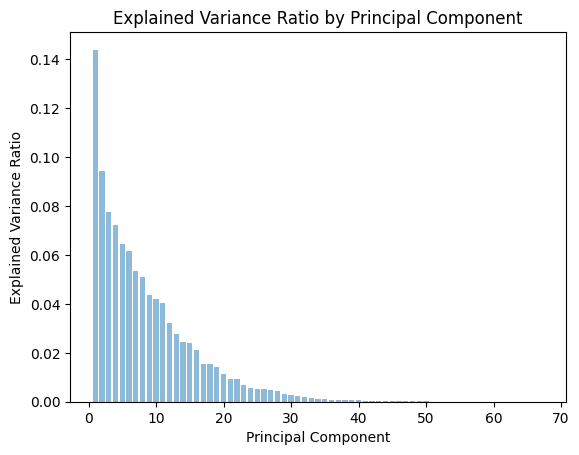

Cumulative Explained Variance:
[0.14390363 0.2382144  0.31597894 0.3882609  0.45285535 0.51439547
 0.56783367 0.61874851 0.66220557 0.70429543 0.74473903 0.77692842
 0.80445301 0.82869502 0.85272788 0.87394175 0.88952964 0.90478461
 0.9189289  0.93015609 0.93945042 0.9485446  0.95538754 0.9608071
 0.9660411  0.97106897 0.97572583 0.9799671  0.98315252 0.98600927
 0.98834066 0.99011515 0.99162207 0.99273255 0.99370822 0.99461108
 0.99547265 0.99616276 0.99682004 0.99744606 0.99791888 0.99826964
 0.99858021 0.99886863 0.99904827 0.99921762 0.99936112 0.99947308
 0.99958468 0.99967831 0.99975082 0.99980564 0.99984247 0.99987558
 0.99990778 0.99993391 0.99995897 0.99997204 0.9999823  0.99999007
 0.99999483 0.99999622 0.99999759 0.99999878 0.99999998 1.
 1.        ]


In [25]:
# Perform PCA
pca = PCA(n_components=X.shape[1])  # Use all components initially
transformed_data = pca.fit_transform(X)

# Compute explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot explained variance ratio
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

# Print cumulative explained variance
print("Cumulative Explained Variance:")
print(cumulative_explained_variance)

# Set threshold for cumulative explained variance
threshold = 0.7  # Adjust based on the desired variance coverage
last_index = np.where(cumulative_explained_variance < threshold)[0][-1]

# Perform PCA again with the selected number of components
pca = PCA(n_components=last_index + 1)
transformed_data = pca.fit_transform(X)

# Retrieve PCA loadings
loadings = pca.components_.T  # Transpose to match the data shape
col_lst = [f'PC{i}' for i in range(1, last_index + 2)]  # Create column names for PCs
loadings_df = pd.DataFrame(loadings, columns=col_lst, index=X.columns)

In [26]:
# Define the threshold for significant individual loading
pca_prct = 0.1  # Adjust this as needed
features_selected_pca_individual = []

# Find features with loadings greater than the threshold for each PC
for PC in col_lst:
    features_selected_pca_individual += list(loadings_df[abs(loadings_df[PC]) > pca_prct].index)

# Remove duplicates
features_selected_pca_individual = list(np.unique(features_selected_pca_individual))

print("\nSelected Features Based on Individual Loadings:")
print(features_selected_pca_individual)


Selected Features Based on Individual Loadings:
['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_EMP_PHONE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_WORK_PHONE', 'HIGHER_EDU', 'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'MARRIED', 'NAME_CONTRACT_TYPE', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_WORK_REGION', 'SUITE_ACCOMPANIED']


In [27]:
# Define the threshold for total loading
pca_prct = 0.7  # Adjust this as needed
features_selected_pca_total = []

# Calculate total loading for each feature
ttl_loading = loadings_df.abs().sum(axis=1)

# Select features with total loading greater than the threshold
features_selected_pca_total = list(ttl_loading[ttl_loading > pca_prct].index)

print("\nSelected Features Based on Total Loadings:")
print(features_selected_pca_total)


Selected Features Based on Total Loadings:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'SUITE_ACCOMPANIED', 'HIGHER_EDU', 'MARRIED']


## Combined Unique Feature Selections

In [28]:
feature_col = list(np.unique(features_selected_pvalue +
                             features_selected_aic +
                             features_selected_bic +
                             features_selected_lasso +
                             features_selected_pca_individual +
                             features_selected_pca_total))
# Number of features initially selected
print(len(feature_col))
feature_col

52


['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_EMAIL',
 'FLAG_EMP_PHONE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'HIGHER_EDU',
 'INCOME_SOURCE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'MARRIED',
 'NAME_CONTRACT_TYPE',
 'REGION_POPULATION_RELATIVE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CIT

In [29]:
features_selected = X[feature_col].copy()
features_selected

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,...,MARRIED,NAME_CONTRACT_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SUITE_ACCOMPANIED
181648,0.051117,0.045573,0.044444,0.000550,0.0,0.000000,0.04,0.20,0.0,0.728918,...,1,0,0.109945,0.5,0.5,0,0,0,0,0
229245,0.050751,0.029146,0.033333,0.000550,0.0,0.000000,0.00,0.10,1.0,0.555468,...,1,0,0.038481,1.0,1.0,0,1,0,0,0
122525,0.101955,0.170748,0.136667,0.000935,0.0,0.000000,0.08,0.05,1.0,0.333822,...,0,0,0.282797,1.0,0.5,0,0,0,0,1
306311,0.134237,0.107162,0.096667,0.000935,0.0,0.000000,0.16,0.05,1.0,0.419278,...,0,0,0.158035,0.5,0.5,0,0,0,0,0
300658,0.106803,0.052360,0.055556,0.001320,0.0,0.000000,0.00,0.05,0.0,0.943799,...,0,0,0.087776,0.5,0.5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,0.078481,0.089888,0.100000,0.000935,0.0,0.000000,0.00,0.15,0.0,0.555524,...,1,1,0.491595,0.5,0.5,0,0,0,0,0
121193,0.083434,0.056809,0.055556,0.001127,0.0,0.000000,0.16,0.05,0.0,0.349154,...,0,0,0.256321,0.5,0.5,0,0,0,0,0
248504,0.094927,0.050276,0.057778,0.000550,0.0,0.000000,0.04,0.10,0.0,0.120688,...,1,0,0.344429,0.5,0.5,0,0,0,0,0
175469,0.104257,0.191011,0.200000,0.000742,0.0,0.000000,0.20,0.10,0.0,0.173675,...,1,0,0.248124,1.0,1.0,0,0,0,0,1


## Remove High Correlations

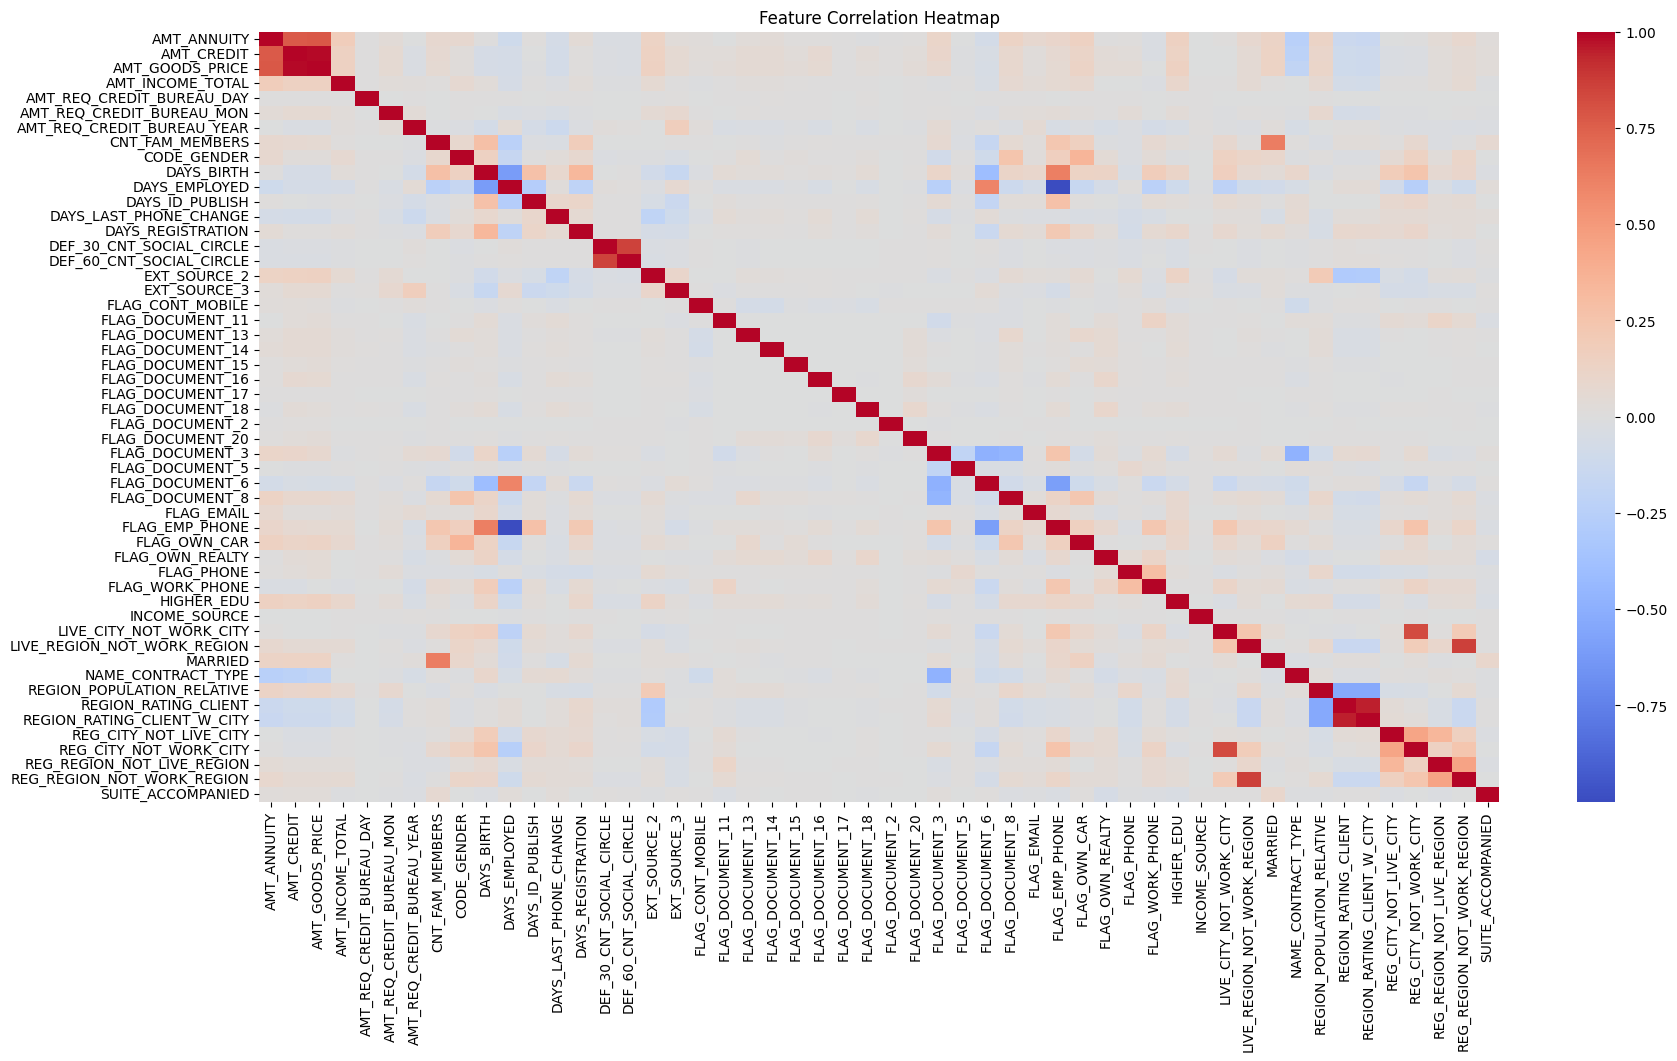

Highly Correlated Features (Threshold = 0.90):
('FLAG_EMP_PHONE', 'DAYS_EMPLOYED')
('REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT')
('AMT_GOODS_PRICE', 'AMT_CREDIT')

Remaining Features After Correlation Filtering:
Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_FAM_MEMBERS', 'CODE_GENDER',
       'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_EMAIL', 'FLAG_EMP_PHONE',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PH

In [30]:
# Define the correlation threshold
corr_threshold = 0.9  # Adjust based on tolerance for multicollinearity

# Compute the correlation matrix for feature_selected
corr_matrix = features_selected.corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, 
            xticklabels=features_selected.columns, 
            yticklabels=features_selected.columns, 
            cmap="coolwarm", 
            annot=False, 
            fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Identify highly correlated features
def get_highly_correlated_features(corr_matrix, threshold):
    """
    Identify pairs of features with correlation above the threshold.
    
    Args:
        corr_matrix (pd.DataFrame): Correlation matrix of the features.
        threshold (float): Correlation threshold.
    
    Returns:
        set: Set of feature pairs with high correlation.
    """
    correlated_pairs = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_pairs.add((corr_matrix.columns[i], corr_matrix.columns[j]))
    return correlated_pairs

high_corr_features = get_highly_correlated_features(corr_matrix, corr_threshold)

# Print highly correlated feature pairs
print("Highly Correlated Features (Threshold = {:.2f}):".format(corr_threshold))
for pair in high_corr_features:
    print(pair)

# Drop one feature from each pair of highly correlated features
features_to_drop = set()
for f1, f2 in high_corr_features:
    features_to_drop.add(f2)  # Arbitrarily choose the second feature to drop

# Remove highly correlated features from the dataset
features_selected_final = features_selected.drop(columns=list(features_to_drop))

# Print resulting feature set
print("\nRemaining Features After Correlation Filtering:")
print(features_selected_final.columns)

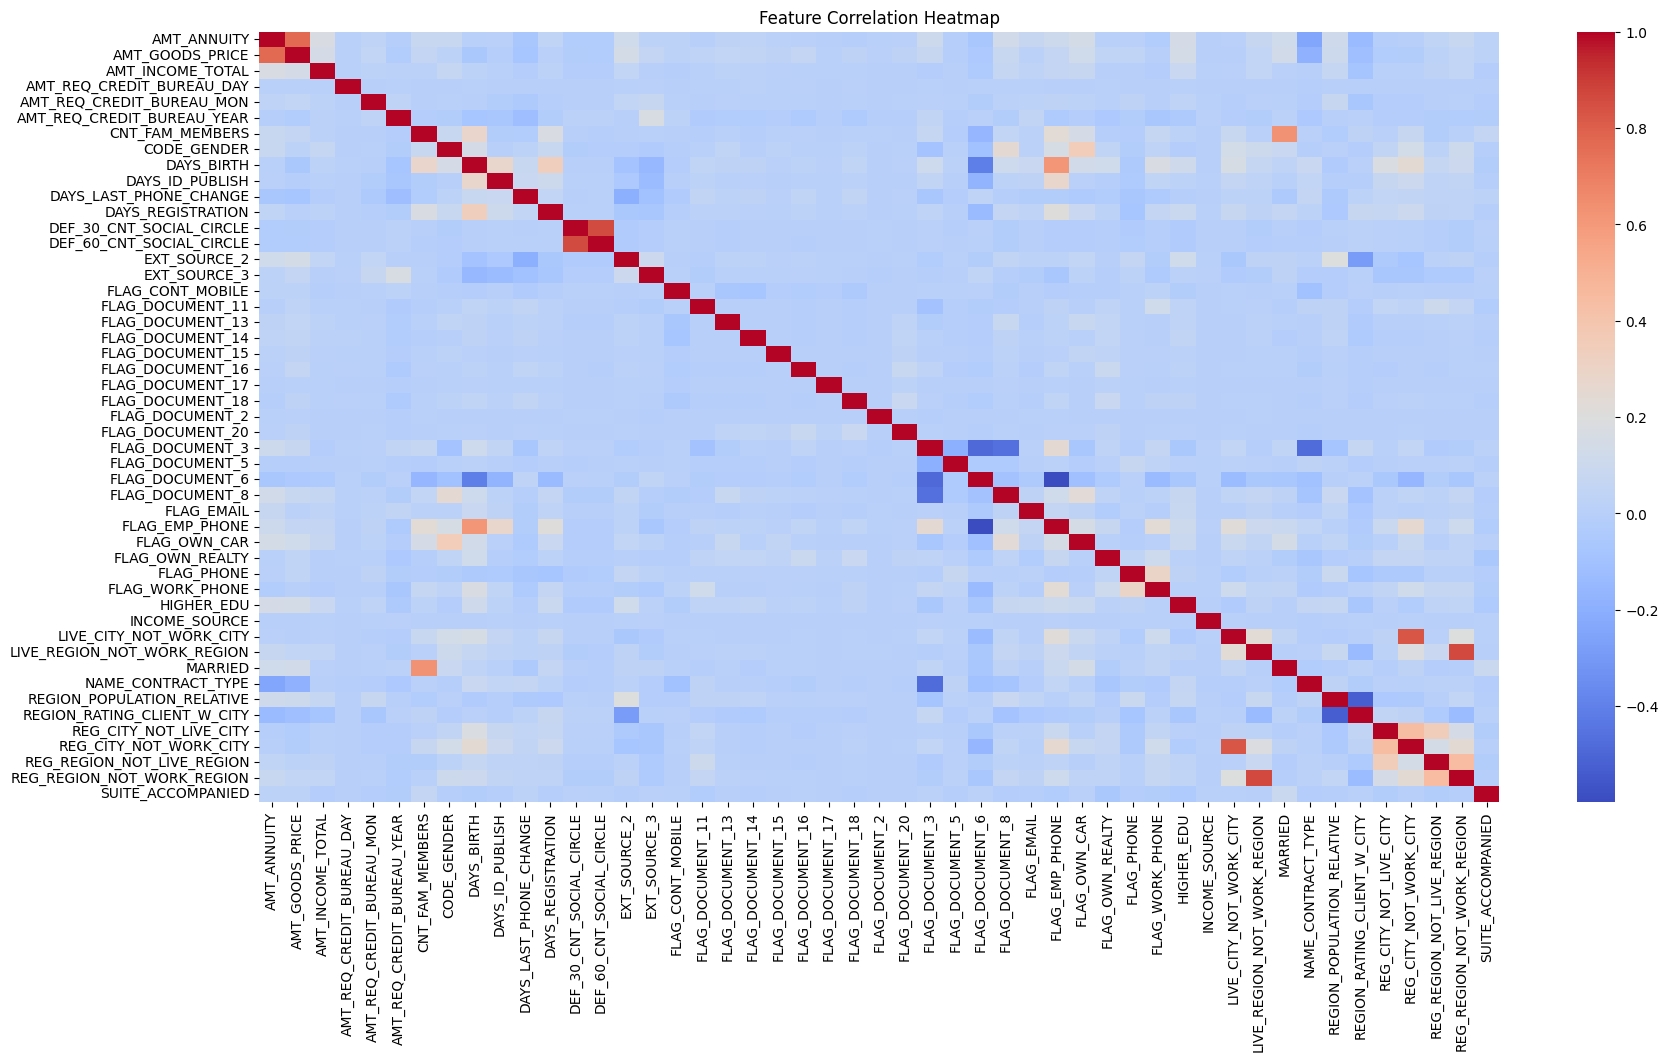

In [31]:
# Compute the correlation matrix for feature_selected
corr_matrix_after = features_selected_final.corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix_after, 
            xticklabels=features_selected_final.columns, 
            yticklabels=features_selected_final.columns, 
            cmap="coolwarm", 
            annot=False, 
            fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [32]:
features_selected_final

,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_ID_PUBLISH,...,LIVE_REGION_NOT_WORK_REGION,MARRIED,NAME_CONTRACT_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SUITE_ACCOMPANIED
181648,0.051117,0.044444,0.000550,0.0,0.000000,0.04,0.20,0.0,0.728918,0.351119,...,0,1,0,0.109945,0.5,0,0,0,0,0
229245,0.050751,0.033333,0.000550,0.0,0.000000,0.00,0.10,1.0,0.555468,0.722940,...,0,1,0,0.038481,1.0,0,1,0,0,0
122525,0.101955,0.136667,0.000935,0.0,0.000000,0.08,0.05,1.0,0.333822,0.605113,...,0,0,0,0.282797,0.5,0,0,0,0,1
306311,0.134237,0.096667,0.000935,0.0,0.000000,0.16,0.05,1.0,0.419278,0.813117,...,0,0,0,0.158035,0.5,0,0,0,0,0
300658,0.106803,0.055556,0.001320,0.0,0.000000,0.00,0.05,0.0,0.943799,0.881617,...,0,0,0,0.087776,0.5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,0.078481,0.100000,0.000935,0.0,0.000000,0.00,0.15,0.0,0.555524,0.385855,...,0,1,1,0.491595,0.5,0,0,0,0,0
121193,0.083434,0.055556,0.001127,0.0,0.000000,0.16,0.05,0.0,0.349154,0.644157,...,0,0,0,0.256321,0.5,0,0,0,0,0
248504,0.094927,0.057778,0.000550,0.0,0.000000,0.04,0.10,0.0,0.120688,0.355843,...,0,1,0,0.344429,0.5,0,0,0,0,0
175469,0.104257,0.200000,0.000742,0.0,0.000000,0.20,0.10,0.0,0.173675,0.355843,...,0,1,0,0.248124,1.0,0,0,0,0,1


In [63]:
features_selected_final.columns

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_FAM_MEMBERS', 'CODE_GENDER',
       'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_EMAIL', 'FLAG_EMP_PHONE',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'HIGHER_EDU', 'INCOME_SOURCE', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'MARRIED', 'NAME_CONTRACT_TYPE',
       'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT_W_

In [33]:
# Define the output path
output_path = r"C:\Users\sxiny\Downloads\12.16 MMF2030 Project\Project\features_selected_final.csv"

# Save the DataFrame to CSV
features_selected_final.to_csv(output_path, index=False)

print(f"File saved successfully to {output_path}")

File saved successfully to C:\Users\sxiny\Downloads\12.16 MMF2030 Project\Project\features_selected_final.csv


# Machine Learning Modelling

In [34]:
# Read the Selected Variables CSV file into a DataFrame
file_path = 'C:/Users/sxiny/Downloads/12.16 MMF2030 Project/Project/'
# file_path = '/Users/shuqichang/Shuqi/School/UT MMF/School/Machine Learning/Assign/Data/'
features_df = pd.read_csv(file_path+'features_selected_final.csv')

# Display the first few rows of the DataFrame
print(features_df.head())

# Get a list of columns (variables)
keep_col_list = features_df.columns.tolist()
print("List of columns:", keep_col_list)

   AMT_ANNUITY  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  AMT_REQ_CREDIT_BUREAU_DAY  \
0     0.051117         0.044444          0.000550                        0.0   
1     0.050751         0.033333          0.000550                        0.0   
2     0.101955         0.136667          0.000935                        0.0   
3     0.134237         0.096667          0.000935                        0.0   
4     0.106803         0.055556          0.001320                        0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_YEAR  CNT_FAM_MEMBERS  \
0                        0.0                        0.04             0.20   
1                        0.0                        0.00             0.10   
2                        0.0                        0.08             0.05   
3                        0.0                        0.16             0.05   
4                        0.0                        0.00             0.05   

   CODE_GENDER  DAYS_BIRTH  DAYS_ID_PUBLISH  ...  LIVE_R

## XBoost

In [43]:
# Define parameter grid
param_grid_xgb = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.3, 0.6, 1.0],
    'subsample': [0.3, 0.6, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Function to train and evaluate XGBoost with profit curve
def xgboost_cv(X_train_set, y_train_set, X_test_set, y_test_set, param_grid, benefit_good=1, cost_bad=5, 
               n_fold=5, random_state=42, scoring='roc_auc'):
    """
    Train and evaluate XGBoost with GridSearchCV, ROC-AUC, and Profit Curve analysis.

    Args:
        X_train_set (pd.DataFrame): Training features.
        y_train_set (pd.Series): Training target.
        X_test_set (pd.DataFrame): Testing features.
        y_test_set (pd.Series): Testing target.
        param_grid (dict): Grid of hyperparameters for tuning.
        benefit_good (int): Benefit of a correct negative prediction.
        cost_bad (int): Cost of a missed positive prediction.
        n_fold (int): Number of cross-validation folds.
        random_state (int): Random seed.
        scoring (str): Scoring metric for GridSearchCV.

    Returns:
        best_xgb_model: Best tuned XGBoost model.
        class_report_test: Classification report on test data.
        profits_test: Profit curve on test set.
    """
    # Initialize XGBoost model
    xgb_model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')

    # GridSearchCV with n-fold cross-validation
    grid_search_xgb = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring=scoring,
        cv=n_fold,
        verbose=2,
        n_jobs=-1
    )

    # Fit the model
    grid_search_xgb.fit(X_train_set, y_train_set)

    # Get the best model
    best_xgb_model = grid_search_xgb.best_estimator_
    print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")

    # Refit the model on training data
    best_xgb_model.fit(X_train_set, y_train_set)
    # Save the model to a local file
    joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

    # --- TRAIN SET PROFIT CURVE ---
    y_pred_proba_train = best_xgb_model.predict_proba(X_train_set)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
    print(f"Tuned XGBoost ROC AUC on Train Set: {roc_auc_train:.2f}")
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
    P_train = sum(y_train_set)  # Total positives
    N_train = len(y_train_set) - P_train  # Total negatives
    TP_train = tpr_train * P_train
    FP_train = fpr_train * N_train
    FN_train = P_train - TP_train
    TN_train = N_train - FP_train
    profits_train = (TN_train * benefit_good) - (FN_train * cost_bad)
    # Optimal threshold for maximum profit
    optimal_idx_train = profits_train.argmax()
    optimal_threshold_train = thresholds_train[optimal_idx_train]
    print(f"Optimal Threshold for Maximum Profit (Train): {optimal_threshold_train:.2f}")
    print(f"Maximum Profit on Training Set: {profits_train[optimal_idx_train]:.2f}")
    # Plot Profit Curve on Train
    plt.plot(thresholds_train, profits_train, label='Profit Curve on Train')
    plt.xlabel("Threshold")
    plt.ylabel("Profit")
    plt.legend(loc='lower right')
    plt.title("Profit Curve on Train Set")
    plt.show()

    # --- TEST SET PROFIT CURVE ---
    y_pred_proba_test = best_xgb_model.predict_proba(X_test_set)[:, 1]
    y_pred_test = (y_pred_proba_test >= optimal_threshold_train).astype(int)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
    optimal_threshold_test_idx = np.where(thresholds_test > optimal_threshold_train)[0][-1]
    P_test = sum(y_test_set)  # Total positives
    N_test = len(y_test_set) - P_test  # Total negatives
    TP_test = tpr_test * P_test
    FP_test = fpr_test * N_test
    FN_test = P_test - TP_test
    TN_test = N_test - FP_test
    profits_test = (TN_test * benefit_good) - (FN_test * cost_bad)
    max_test_profit = profits_test[optimal_threshold_test_idx]
    # Plot Profit Curve on Test
    plt.plot(thresholds_test, profits_test, label='Profit Curve on Test')
    plt.xlabel("Threshold")
    plt.ylabel("Profit")
    plt.legend(loc='lower right')
    plt.title("Profit Curve on Test Set")
    plt.show()

    # Evaluate ROC-AUC and Profit on Test Set
    roc_auc_test = roc_auc_score(y_test_set, y_pred_proba_test)
    print(f"Tuned XGBoost ROC AUC on Test Set: {roc_auc_test:.2f}")
    print(f"Maximum Profit on Test Set: {max_test_profit:.2f}")

    # Classification report
    print("Classification Report for Tuned XGBoost on Test Set:")
    class_report_test = classification_report(y_test_set, y_pred_test, target_names=['non-default', 'default'])
    print(class_report_test)

    return best_xgb_model, fpr_test, tpr_test, thresholds_test, roc_auc_test, y_pred_test, optimal_threshold_train, class_report_test, profits_test, max_test_profit

### ROC AUC

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\sxiny\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [04:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 1, 'subsample': 1.0}


c:\Users\sxiny\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [04:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tuned XGBoost ROC AUC on Train Set: 0.77
Optimal Threshold for Maximum Profit (Train): 0.16
Maximum Profit on Training Set: 143776.00


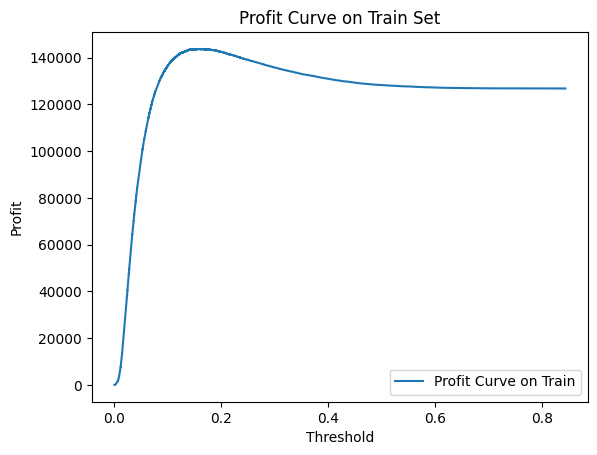

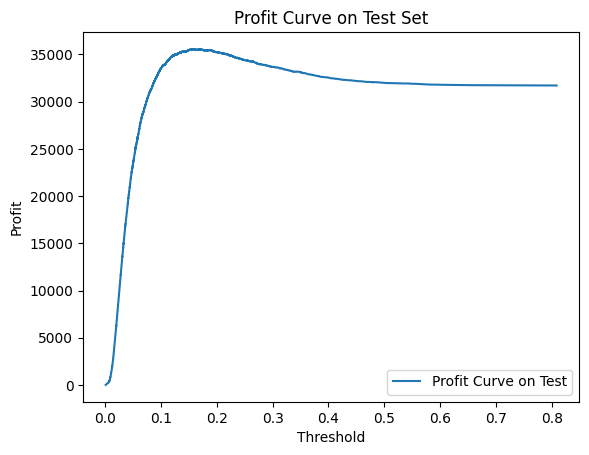

Tuned XGBoost ROC AUC on Test Set: 0.75
Maximum Profit on Test Set: 35542.00
Classification Report for Tuned XGBoost on Test Set:
              precision    recall  f1-score   support

 non-default       0.94      0.90      0.92     56538
     default       0.25      0.39      0.30      4965

    accuracy                           0.86     61503
   macro avg       0.60      0.64      0.61     61503
weighted avg       0.89      0.86      0.87     61503

CPU times: total: 3min 7s
Wall time: 2h 43min 14s


In [44]:
%%time
best_xgb_model, fpr_xgb, tpr_xgb, thresholds_xgb, roc_auc_xgb, y_pred_custom_xgb, optimal_threshold_xgb, class_report_xgb, profits_xgb, max_profit_xgb = xgboost_cv(
    X_train[keep_col_list], y_train, 
    X_test[keep_col_list], y_test, 
    param_grid_xgb, 
    n_fold=5, 
    random_state=42, 
    scoring='roc_auc'
)

In [45]:
# Save the model to a local file
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

### F1 Score

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\sxiny\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [07:03:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 5, 'subsample': 0.6}


c:\Users\sxiny\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [07:04:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tuned XGBoost ROC AUC on Train Set: 0.77
Optimal Threshold for Maximum Profit (Train): 0.47
Maximum Profit on Training Set: 143419.00


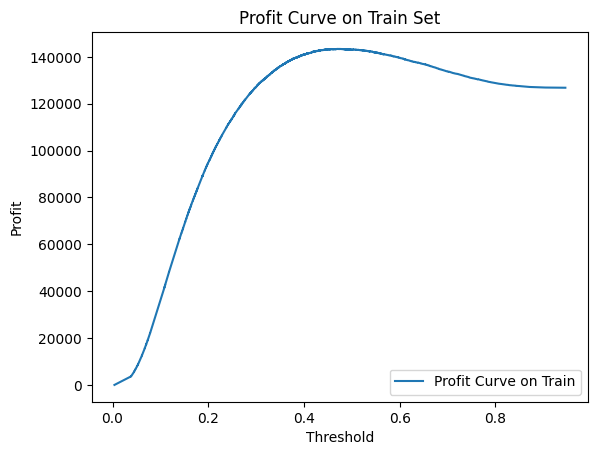

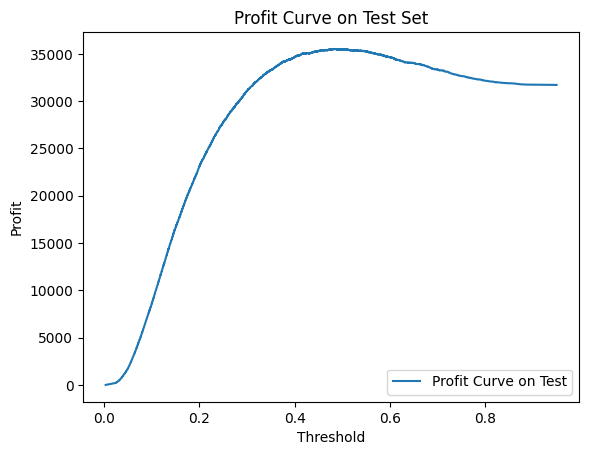

Tuned XGBoost ROC AUC on Test Set: 0.75
Maximum Profit on Test Set: 35389.00
Classification Report for Tuned XGBoost on Test Set:
              precision    recall  f1-score   support

 non-default       0.94      0.89      0.92     56538
     default       0.24      0.40      0.30      4965

    accuracy                           0.85     61503
   macro avg       0.59      0.64      0.61     61503
weighted avg       0.89      0.85      0.87     61503

CPU times: total: 2min 51s
Wall time: 2h 36min 18s


In [46]:
%%time
best_xgb_model_F1, fpr_xgb_F1, tpr_xgb_F1, thresholds_xgb_F1, roc_auc_xgb_F1, y_pred_custom_xgb_F1, optimal_threshold_xgb_F1, class_report_xgb_F1, profits_xgb, max_profit_xgb_F1 = xgboost_cv(
    X_train[keep_col_list], y_train, 
    X_test[keep_col_list], y_test, 
    param_grid_xgb, 
    n_fold=5, 
    random_state=42, 
    scoring='f1'
)

In [47]:
# Save the model to a local file
joblib.dump(best_xgb_model_F1, 'best_xgb_model_F1.pkl')

['best_xgb_model_F1.pkl']

## Random Forest

In [48]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

def random_forest_cv(X_train_set, y_train_set, X_test_set, y_test_set, param_grid, benefit_good=1, cost_bad=5, 
                     n_fold=5, random_state=42, scoring='roc_auc'):
    """
    Train and evaluate Random Forest with GridSearchCV, ROC-AUC, and Profit Curve analysis.
    """
    # Initialize Random Forest model
    rf_model = RandomForestClassifier(random_state=random_state)

    # GridSearchCV with n-fold cross-validation
    grid_search_rf = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        scoring=scoring,
        cv=n_fold,
        verbose=2,
        n_jobs=-1
    )

    # Fit the model
    grid_search_rf.fit(X_train_set, y_train_set)

    # Get the best model
    best_rf_model = grid_search_rf.best_estimator_
    print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
    # Save the model to a local file
    joblib.dump(best_rf_model, 'best_rf_model.pkl')

    # --- TRAIN SET PROFIT CURVE ---
    y_pred_proba_train = best_rf_model.predict_proba(X_train_set)[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_set, y_pred_proba_train)
    P_train = sum(y_train_set)
    N_train = len(y_train_set) - P_train
    TP_train = tpr_train * P_train
    FP_train = fpr_train * N_train
    FN_train = P_train - TP_train
    TN_train = N_train - FP_train
    profits_train = (TN_train * benefit_good) - (FN_train * cost_bad)

    # Optimal threshold for maximum profit
    optimal_idx_train = profits_train.argmax()
    optimal_threshold_train = thresholds_train[optimal_idx_train]

    # --- TEST SET PROFIT CURVE ---
    y_pred_proba_test = best_rf_model.predict_proba(X_test_set)[:, 1]
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_set, y_pred_proba_test)
    y_pred_test = (y_pred_proba_test >= optimal_threshold_train).astype(int)

    # Evaluate ROC-AUC
    roc_auc_rf = roc_auc_score(y_test_set, y_pred_proba_test)
    print(f"Tuned Random Forest ROC AUC on Test Set: {roc_auc_rf:.2f}")

    # Classification report
    class_report_rf = classification_report(y_test_set, y_pred_test, target_names=['non-default', 'default'])
    print("Classification Report for Tuned Random Forest on Test Set:")
    print(class_report_rf)
    
    
    
        # --- TRAIN SET PROFIT CURVE ---
    y_pred_proba_train = best_rf_model.predict_proba(X_train_set)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
    print(f"Tuned Random Forest ROC AUC on Train Set: {roc_auc_train:.2f}")
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
    P_train = sum(y_train_set)  # Total positives
    N_train = len(y_train_set) - P_train  # Total negatives
    TP_train = tpr_train * P_train
    FP_train = fpr_train * N_train
    FN_train = P_train - TP_train
    TN_train = N_train - FP_train
    profits_train = (TN_train * benefit_good) - (FN_train * cost_bad)
    # Optimal threshold for maximum profit
    optimal_idx_train = profits_train.argmax()
    optimal_threshold_train = thresholds_train[optimal_idx_train]
    print(f"Optimal Threshold for Maximum Profit (Train): {optimal_threshold_train:.2f}")
    print(f"Maximum Profit on Training Set: {profits_train[optimal_idx_train]:.2f}")
    # Plot Profit Curve on Train
    plt.plot(thresholds_train, profits_train, label='Profit Curve on Train')
    plt.xlabel("Threshold")
    plt.ylabel("Profit")
    plt.legend(loc='lower right')
    plt.title("Profit Curve on Train Set")
    plt.show()

    # --- TEST SET PROFIT CURVE ---
    y_pred_proba_test = best_rf_model.predict_proba(X_test_set)[:, 1]
    y_pred_test = (y_pred_proba_test >= optimal_threshold_train).astype(int)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
    optimal_threshold_test_idx = np.where(thresholds_test > optimal_threshold_train)[0][-1]
    P_test = sum(y_test_set)  # Total positives
    N_test = len(y_test_set) - P_test  # Total negatives
    TP_test = tpr_test * P_test
    FP_test = fpr_test * N_test
    FN_test = P_test - TP_test
    TN_test = N_test - FP_test
    profits_test = (TN_test * benefit_good) - (FN_test * cost_bad)
    max_test_profit = profits_test[optimal_threshold_test_idx]
    # Plot Profit Curve on Test
    plt.plot(thresholds_test, profits_test, label='Profit Curve on Test')
    plt.xlabel("Threshold")
    plt.ylabel("Profit")
    plt.legend(loc='lower right')
    plt.title("Profit Curve on Test Set")
    plt.show()

    # Evaluate ROC-AUC and Profit on Test Set
    roc_auc_test = roc_auc_score(y_test_set, y_pred_proba_test)
    print(f"Tuned Random Forest ROC AUC on Test Set: {roc_auc_test:.2f}")
    print(f"Maximum Profit on Test Set: {max_test_profit:.2f}")

    # Classification report
    print("Classification Report for Tuned Random Forest on Test Set:")
    class_report_test = classification_report(y_test_set, y_pred_test, target_names=['non-default', 'default'])
    print(class_report_test)

    return best_rf_model, fpr_test, tpr_test, thresholds_test, roc_auc_test, y_pred_test, optimal_threshold_train, class_report_test, profits_test, max_test_profit

### ROC AUC

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Random Forest Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Random Forest ROC AUC on Test Set: 0.74
Classification Report for Tuned Random Forest on Test Set:
              precision    recall  f1-score   support

 non-default       0.94      0.88      0.91     56538
     default       0.22      0.39      0.28      4965

    accuracy                           0.84     61503
   macro avg       0.58      0.63      0.60     61503
weighted avg       0.88      0.84      0.86     61503

Tuned Random Forest ROC AUC on Train Set: 0.92
Optimal Threshold for Maximum Profit (Train): 0.14
Maximum Profit on Training Set: 178928.00


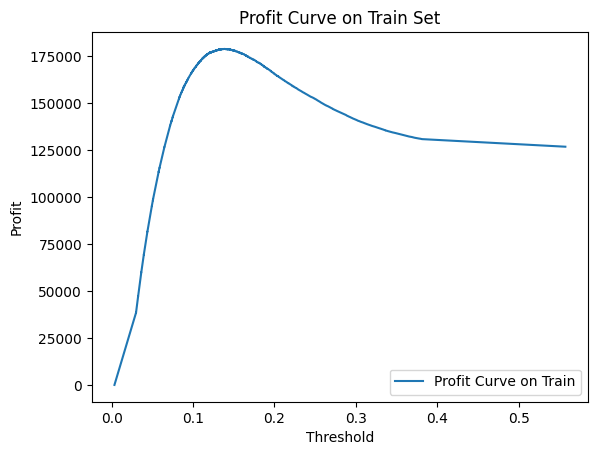

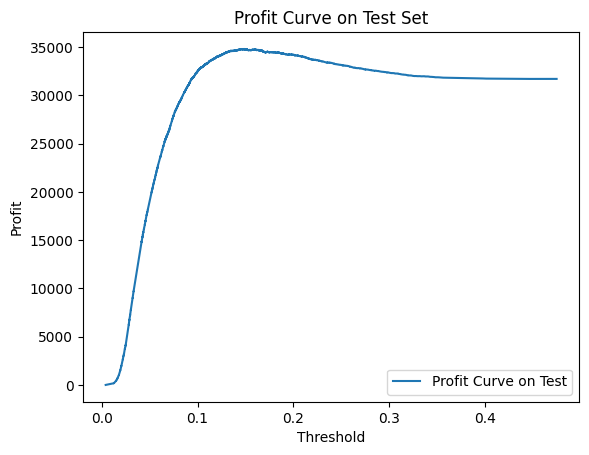

Tuned Random Forest ROC AUC on Test Set: 0.74
Maximum Profit on Test Set: 34636.00
Classification Report for Tuned Random Forest on Test Set:
              precision    recall  f1-score   support

 non-default       0.94      0.88      0.91     56538
     default       0.22      0.39      0.28      4965

    accuracy                           0.84     61503
   macro avg       0.58      0.63      0.60     61503
weighted avg       0.88      0.84      0.86     61503

CPU times: total: 2min 29s
Wall time: 1h 2min 44s


In [49]:
%%time
best_rf_model, fpr_rf, tpr_rf, thresholds_rf, roc_auc_rf, y_pred_custom_rf, optimal_threshold_rf, class_report_rf, profits_rf, max_profit_rf = random_forest_cv(
    X_train[keep_col_list], y_train, X_test[keep_col_list], y_test, param_grid_rf, n_fold=3, random_state=42, scoring='roc_auc'
)

In [50]:
# Save the model to a local file
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

### F1 Score

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Random Forest Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Tuned Random Forest ROC AUC on Test Set: 0.73
Classification Report for Tuned Random Forest on Test Set:
              precision    recall  f1-score   support

 non-default       0.94      0.89      0.91     56538
     default       0.22      0.36      0.27      4965

    accuracy                           0.84     61503
   macro avg       0.58      0.62      0.59     61503
weighted avg       0.88      0.84      0.86     61503

Tuned Random Forest ROC AUC on Train Set: 0.91
Optimal Threshold for Maximum Profit (Train): 0.14
Maximum Profit on Training Set: 176896.00


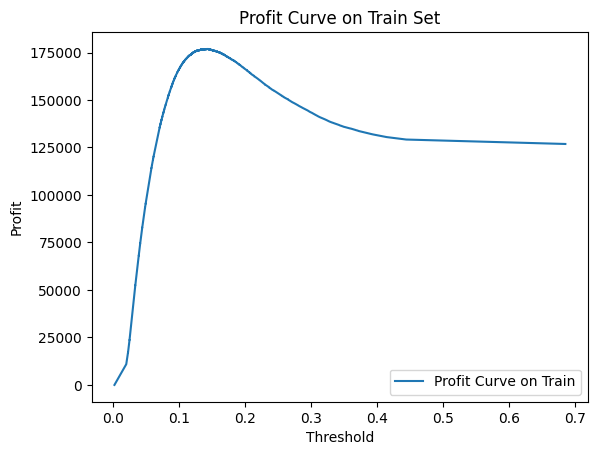

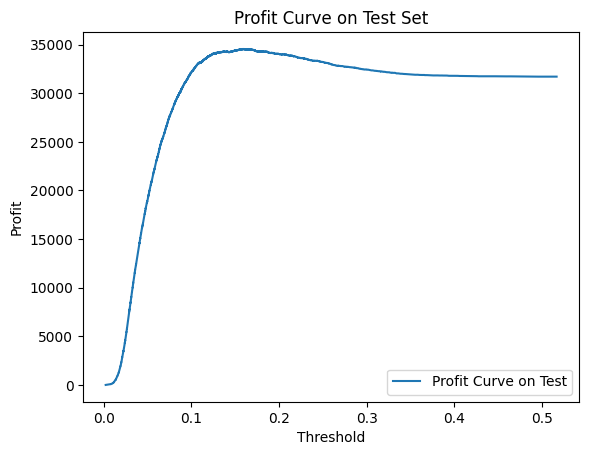

Tuned Random Forest ROC AUC on Test Set: 0.73
Maximum Profit on Test Set: 34247.00
Classification Report for Tuned Random Forest on Test Set:
              precision    recall  f1-score   support

 non-default       0.94      0.89      0.91     56538
     default       0.22      0.36      0.27      4965

    accuracy                           0.84     61503
   macro avg       0.58      0.62      0.59     61503
weighted avg       0.88      0.84      0.86     61503

CPU times: total: 44.2 s
Wall time: 1h 59s


In [51]:
%%time
best_rf_model_F1, fpr_rf_F1, tpr_rf_F1, thresholds_rf_F1, roc_auc_rf_F1, y_pred_custom_rf_F1, optimal_threshold_rf_F1, class_report_F1, profits_rf_F1, max_profit_rf_F1 = random_forest_cv(
    X_train[keep_col_list], y_train, X_test[keep_col_list], y_test, param_grid_rf, n_fold=3, random_state=42, scoring='f1'
)

In [52]:
# Save the model to a local file
joblib.dump(best_rf_model_F1, 'best_rf_model_F1.pkl')

['best_rf_model_F1.pkl']

# Performance Testing

In [76]:
def plot_feature_importance(model, X_train_set, threshold = 0.005, model_name='xgb'):
    # Get feature importances
    importances = model.feature_importances_
    feature_names = X_train_set.columns if hasattr(X_train_set, 'columns') else [f"Feature {i}" for i in range(X_train_set.shape[1])]
    sorted_idx = np.argsort(importances)

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importances)), importances[sorted_idx], align='center')
    plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
    if model_name == 'rf':
        plt.title("Random Forest Feature Importance")
    elif model_name == 'xgb':
        plt.title("XGBoost Feature Importance")
    plt.show()


    # Filter features with importance > 0.005
    filtered_idx = [i for i in range(len(importances)) if importances[i] > threshold]
    filtered_importances = importances[filtered_idx]
    filtered_feature_names = [feature_names[i] for i in filtered_idx]

    # Sort the filtered features by importance
    sorted_idx = np.argsort(filtered_importances)
    sorted_importances = filtered_importances[sorted_idx]
    sorted_feature_names = [filtered_feature_names[i] for i in sorted_idx]

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    if model_name == 'rf':
        plt.title("Random Forest Feature Importance (Filtered) at threshold="+str(threshold))
    elif model_name == 'xgb':
        plt.title("XGBoost Feature Importance (Filtered) at threshold="+str(threshold))
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

## XBoost

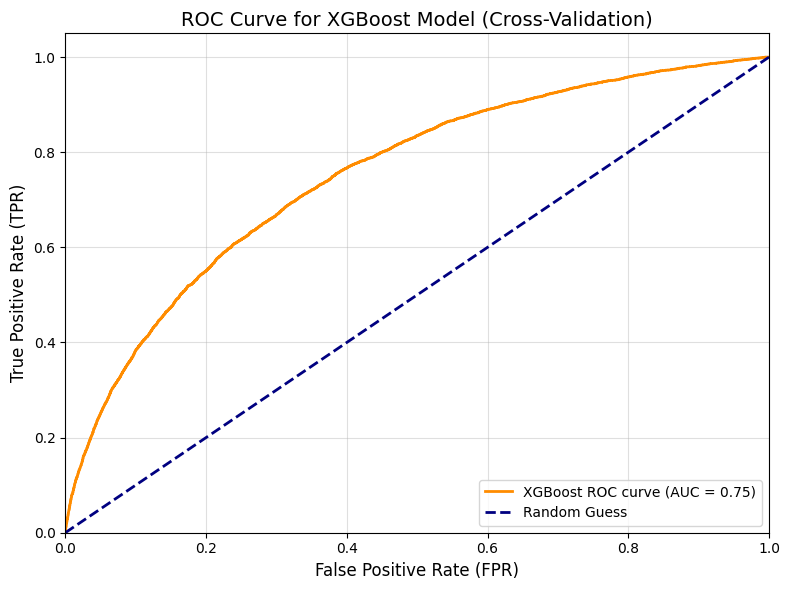

In [77]:
# Ensure variables like `fpr_xgb_cross` and `tpr_xgb_cross` contain the False Positive Rates and True Positive Rates

roc_auc_xgb = auc(fpr_xgb, tpr_xgb)  # Redundant if `roc_auc_rf_cross` is already accurate

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb:.2f})')

# Add baseline (random guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for XGBoost Model (Cross-Validation)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

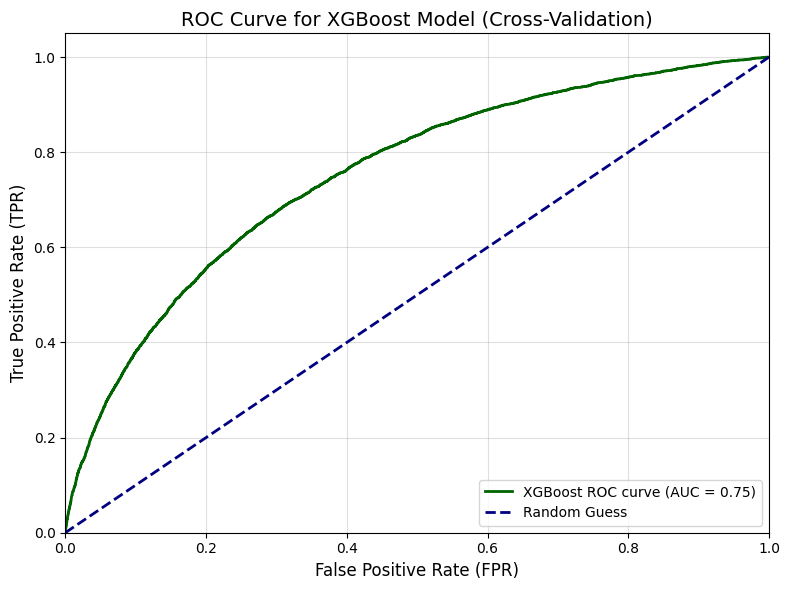

In [78]:
# Ensure the variables like `fpr_rf` and `tpr_rf` contain the False Positive Rates and True Positive Rates
# Calculate the AUC if needed (already computed as `roc_auc_xgb`)
roc_auc_xgb_calculated = auc(fpr_xgb_F1, tpr_xgb_F1)  # Optional if `roc_auc_xgb` is already accurate

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_F1, tpr_xgb_F1, color='darkgreen', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb_calculated:.2f})')

# Add baseline (random guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for XGBoost Model (Cross-Validation)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

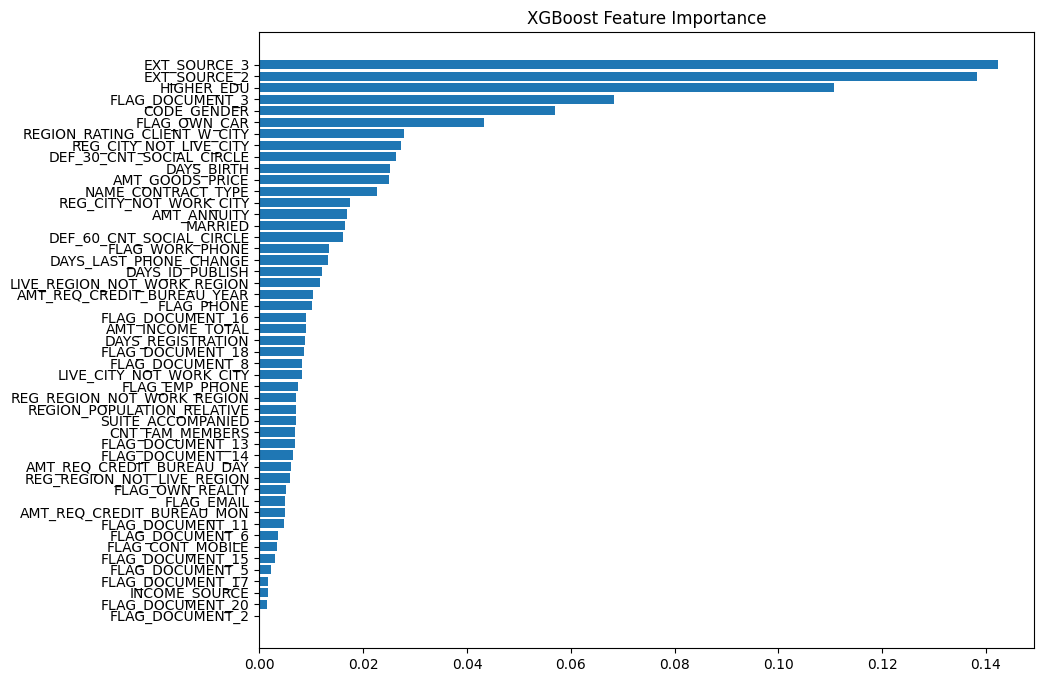

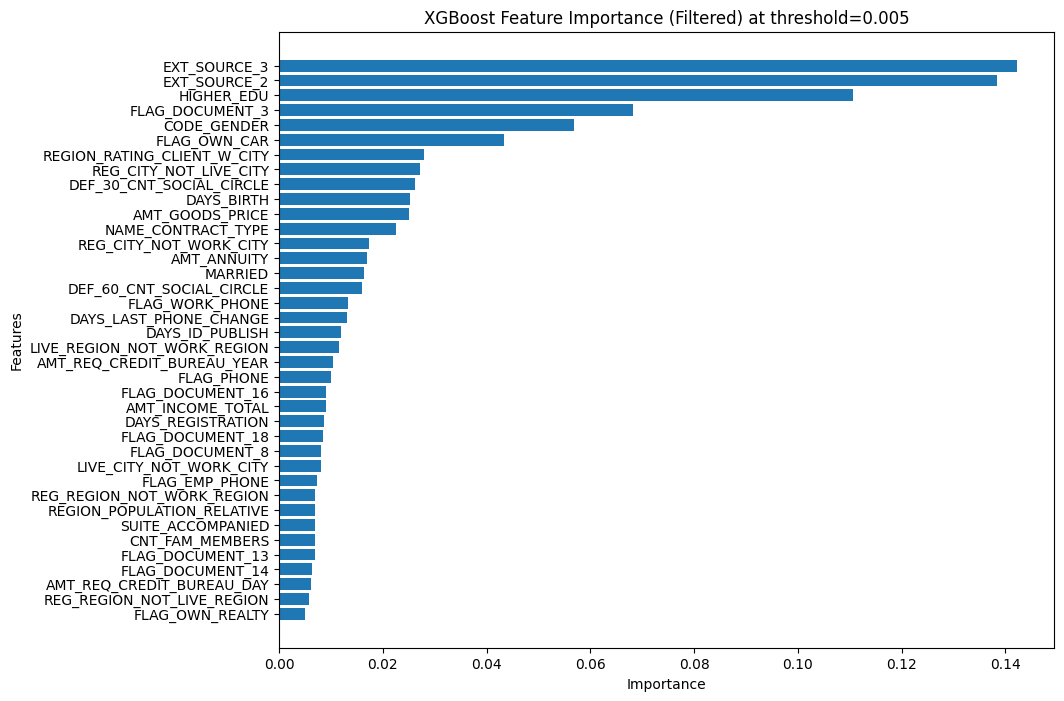

In [79]:
plot_feature_importance(best_xgb_model, X_train[keep_col_list], threshold = 0.005, model_name='xgb')

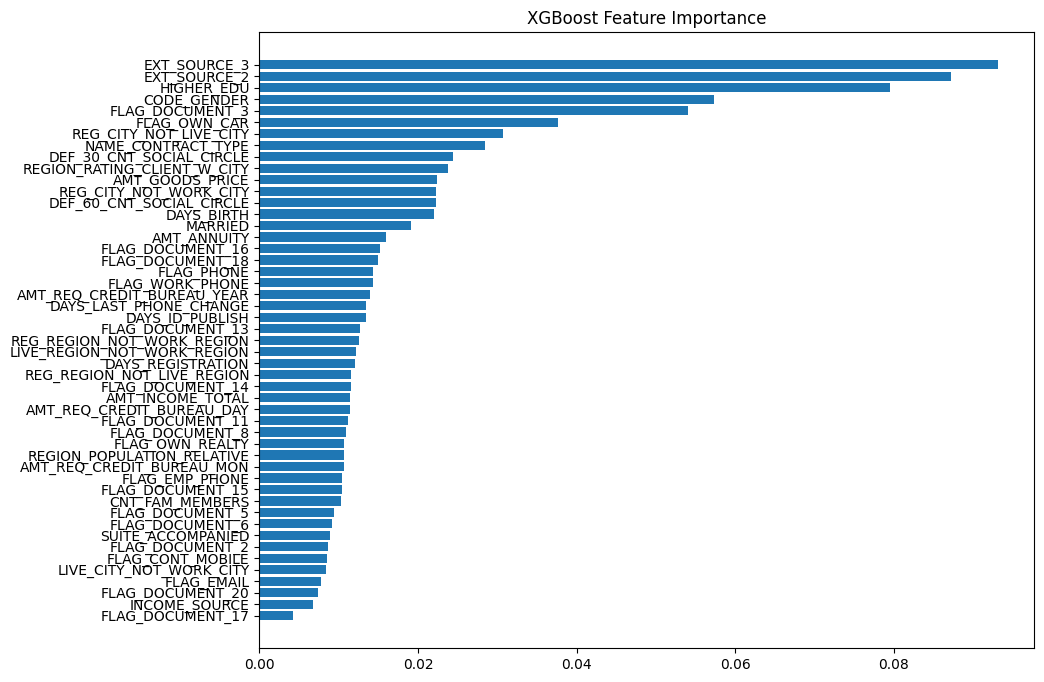

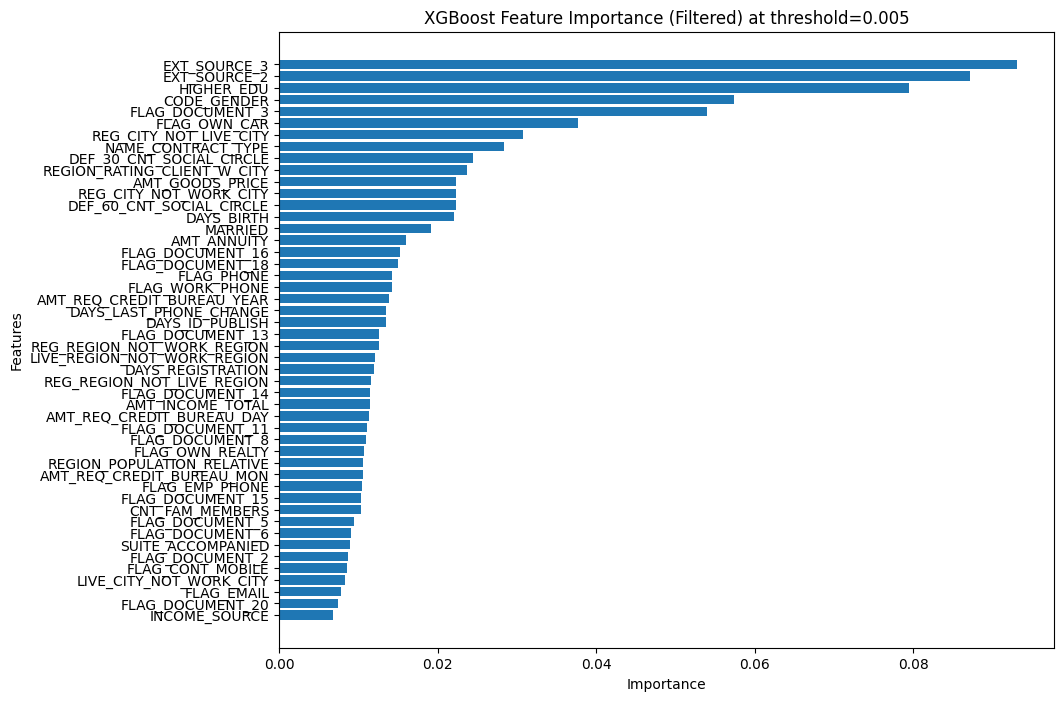

In [80]:
plot_feature_importance(best_xgb_model_F1, X_train[keep_col_list], threshold = 0.005, model_name='xgb')

## Random Forest

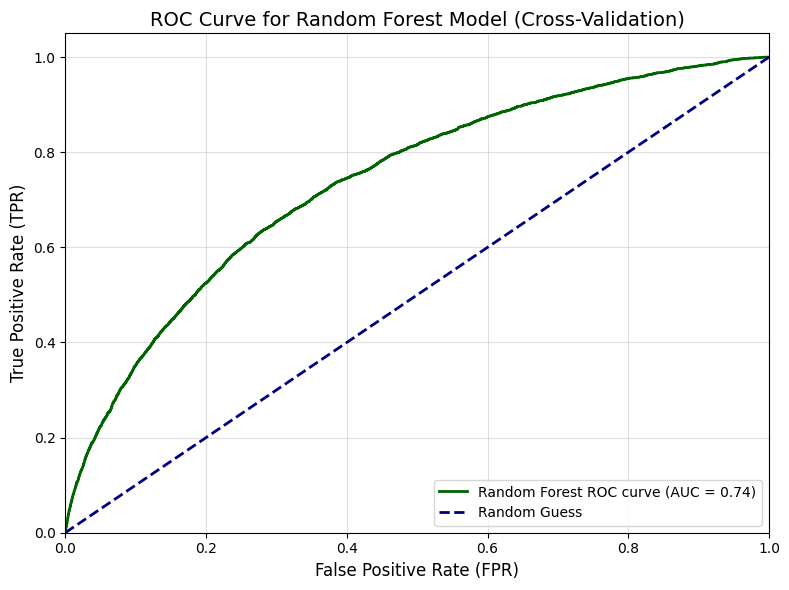

In [81]:
# Ensure the variables like `fpr_rf` and `tpr_rf` contain the False Positive Rates and True Positive Rates
# y_validation_pred = best_rf_model.predict(X_val[keep_col_list])
# fpr, tpr, thresholds = roc_curve(y_val, y_validation_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})')

# Add baseline (random guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Random Forest Model (Cross-Validation)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

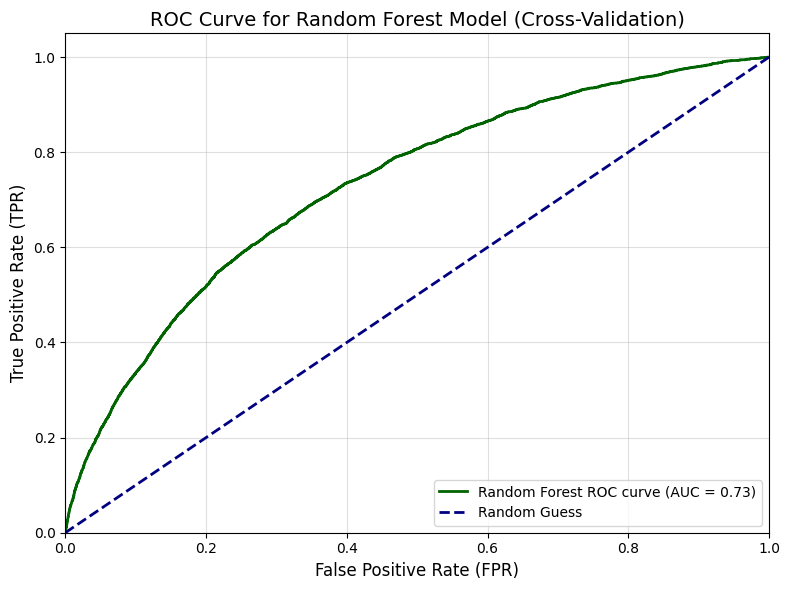

In [82]:
# Ensure the variables like `fpr_rf` and `tpr_rf` contain the False Positive Rates and True Positive Rates
# Calculate the AUC if needed (already computed as `roc_auc_rf`)
roc_auc_rf_calculated = auc(fpr_rf_F1, tpr_rf_F1)  # Optional if `roc_auc_rf` is already accurate

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_F1, tpr_rf_F1, color='darkgreen', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf_calculated:.2f})')

# Add baseline (random guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Random Forest Model (Cross-Validation)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

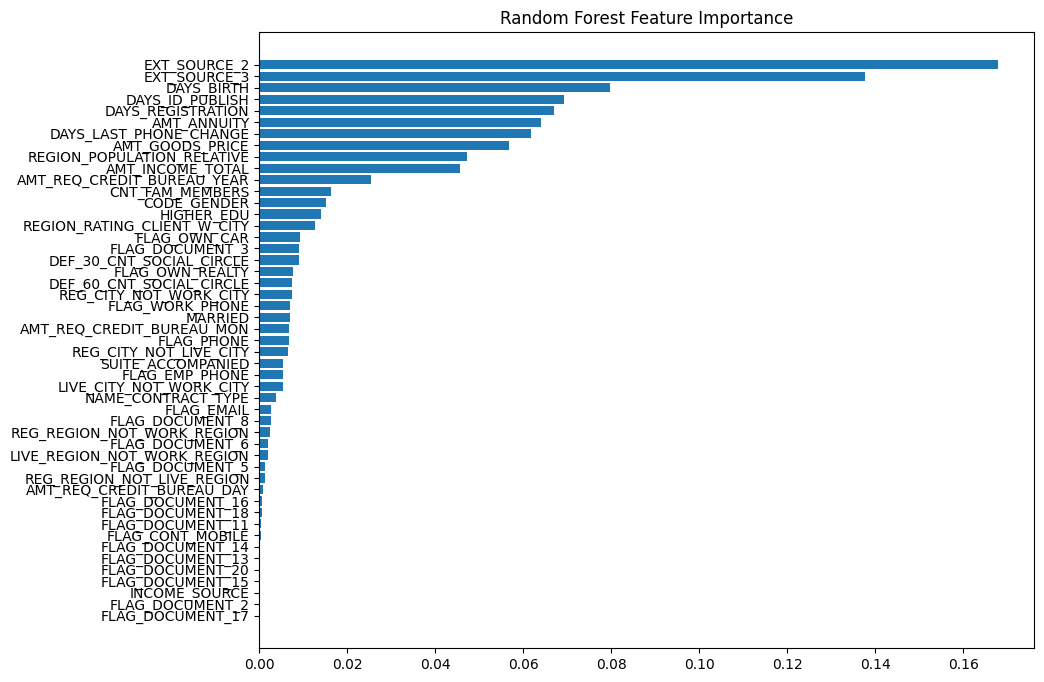

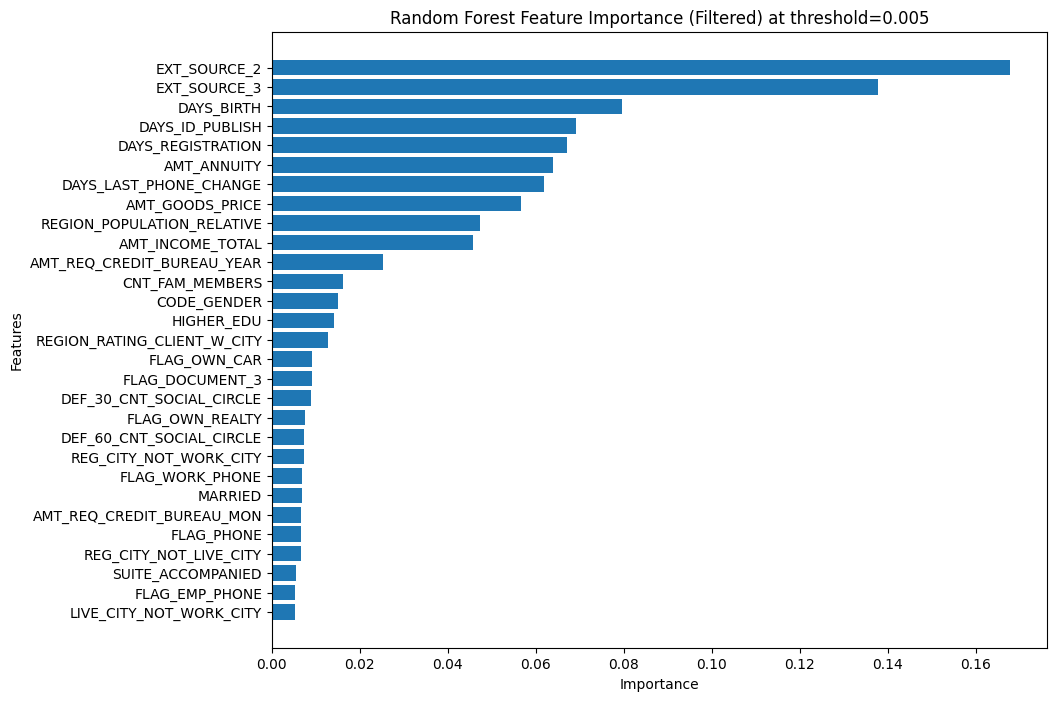

In [83]:
plot_feature_importance(best_rf_model, X_train[keep_col_list], threshold = 0.005, model_name='rf')

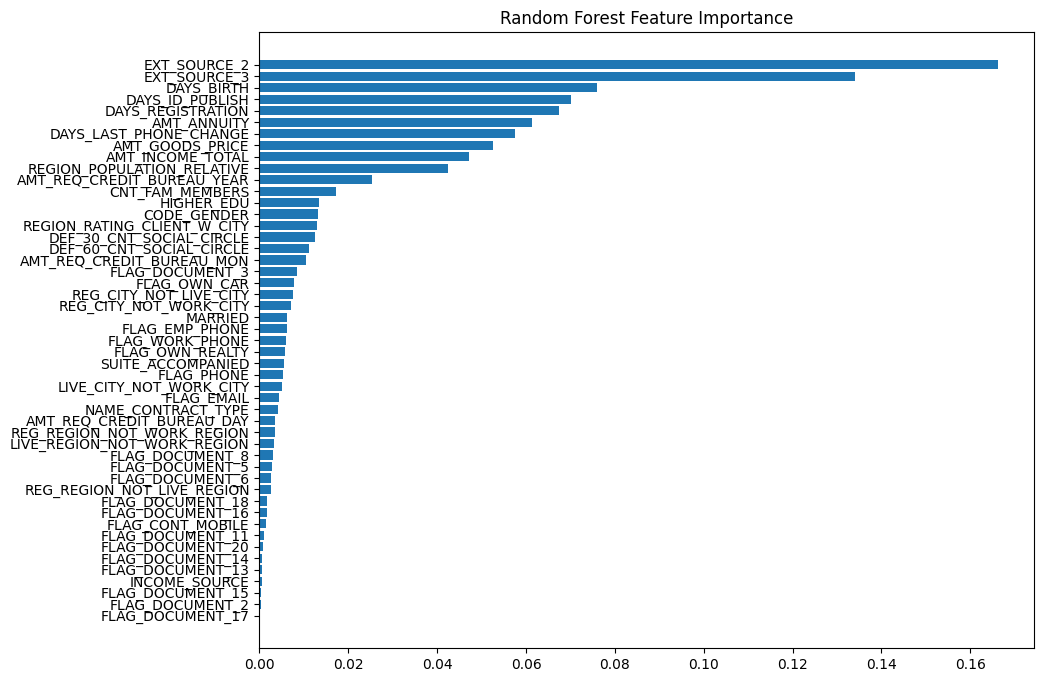

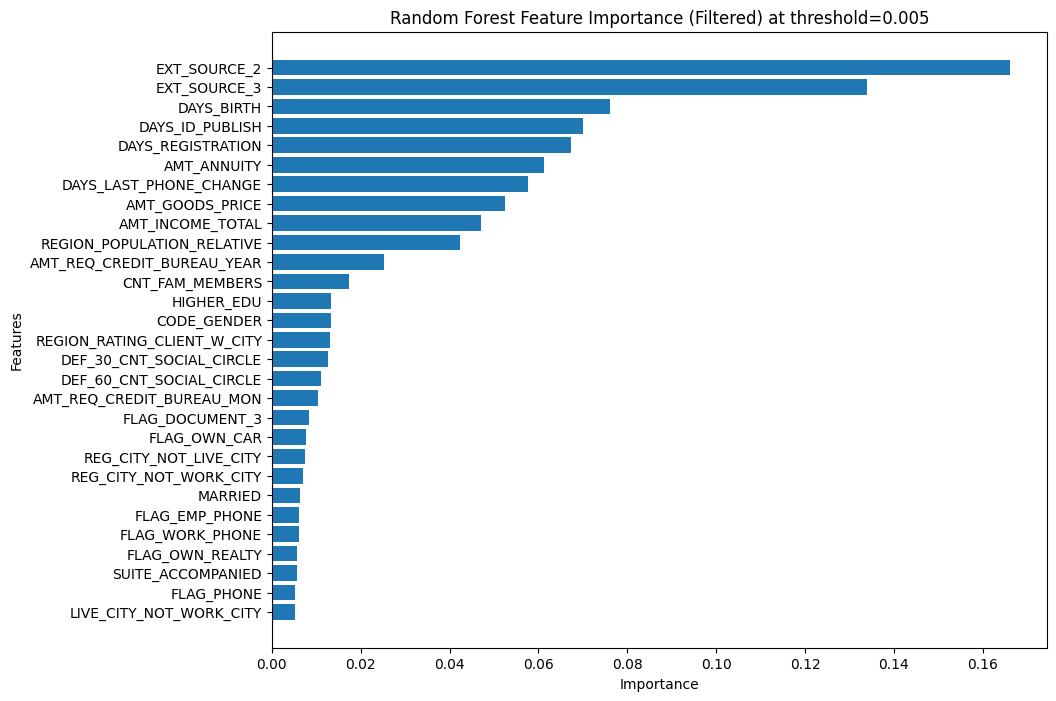

In [84]:
plot_feature_importance(best_rf_model_F1, X_train[keep_col_list], threshold = 0.005, model_name='rf')